In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [13, 8]

In [3]:
p_true = [2, 0.5, 3]
tspan = [0, 30]
def system(t, y, p):
    return [
        p[0]*p[2] - p[1]*y[0]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [1], dense_output=True)

Text(0.5, 0, 'Time, $t$')

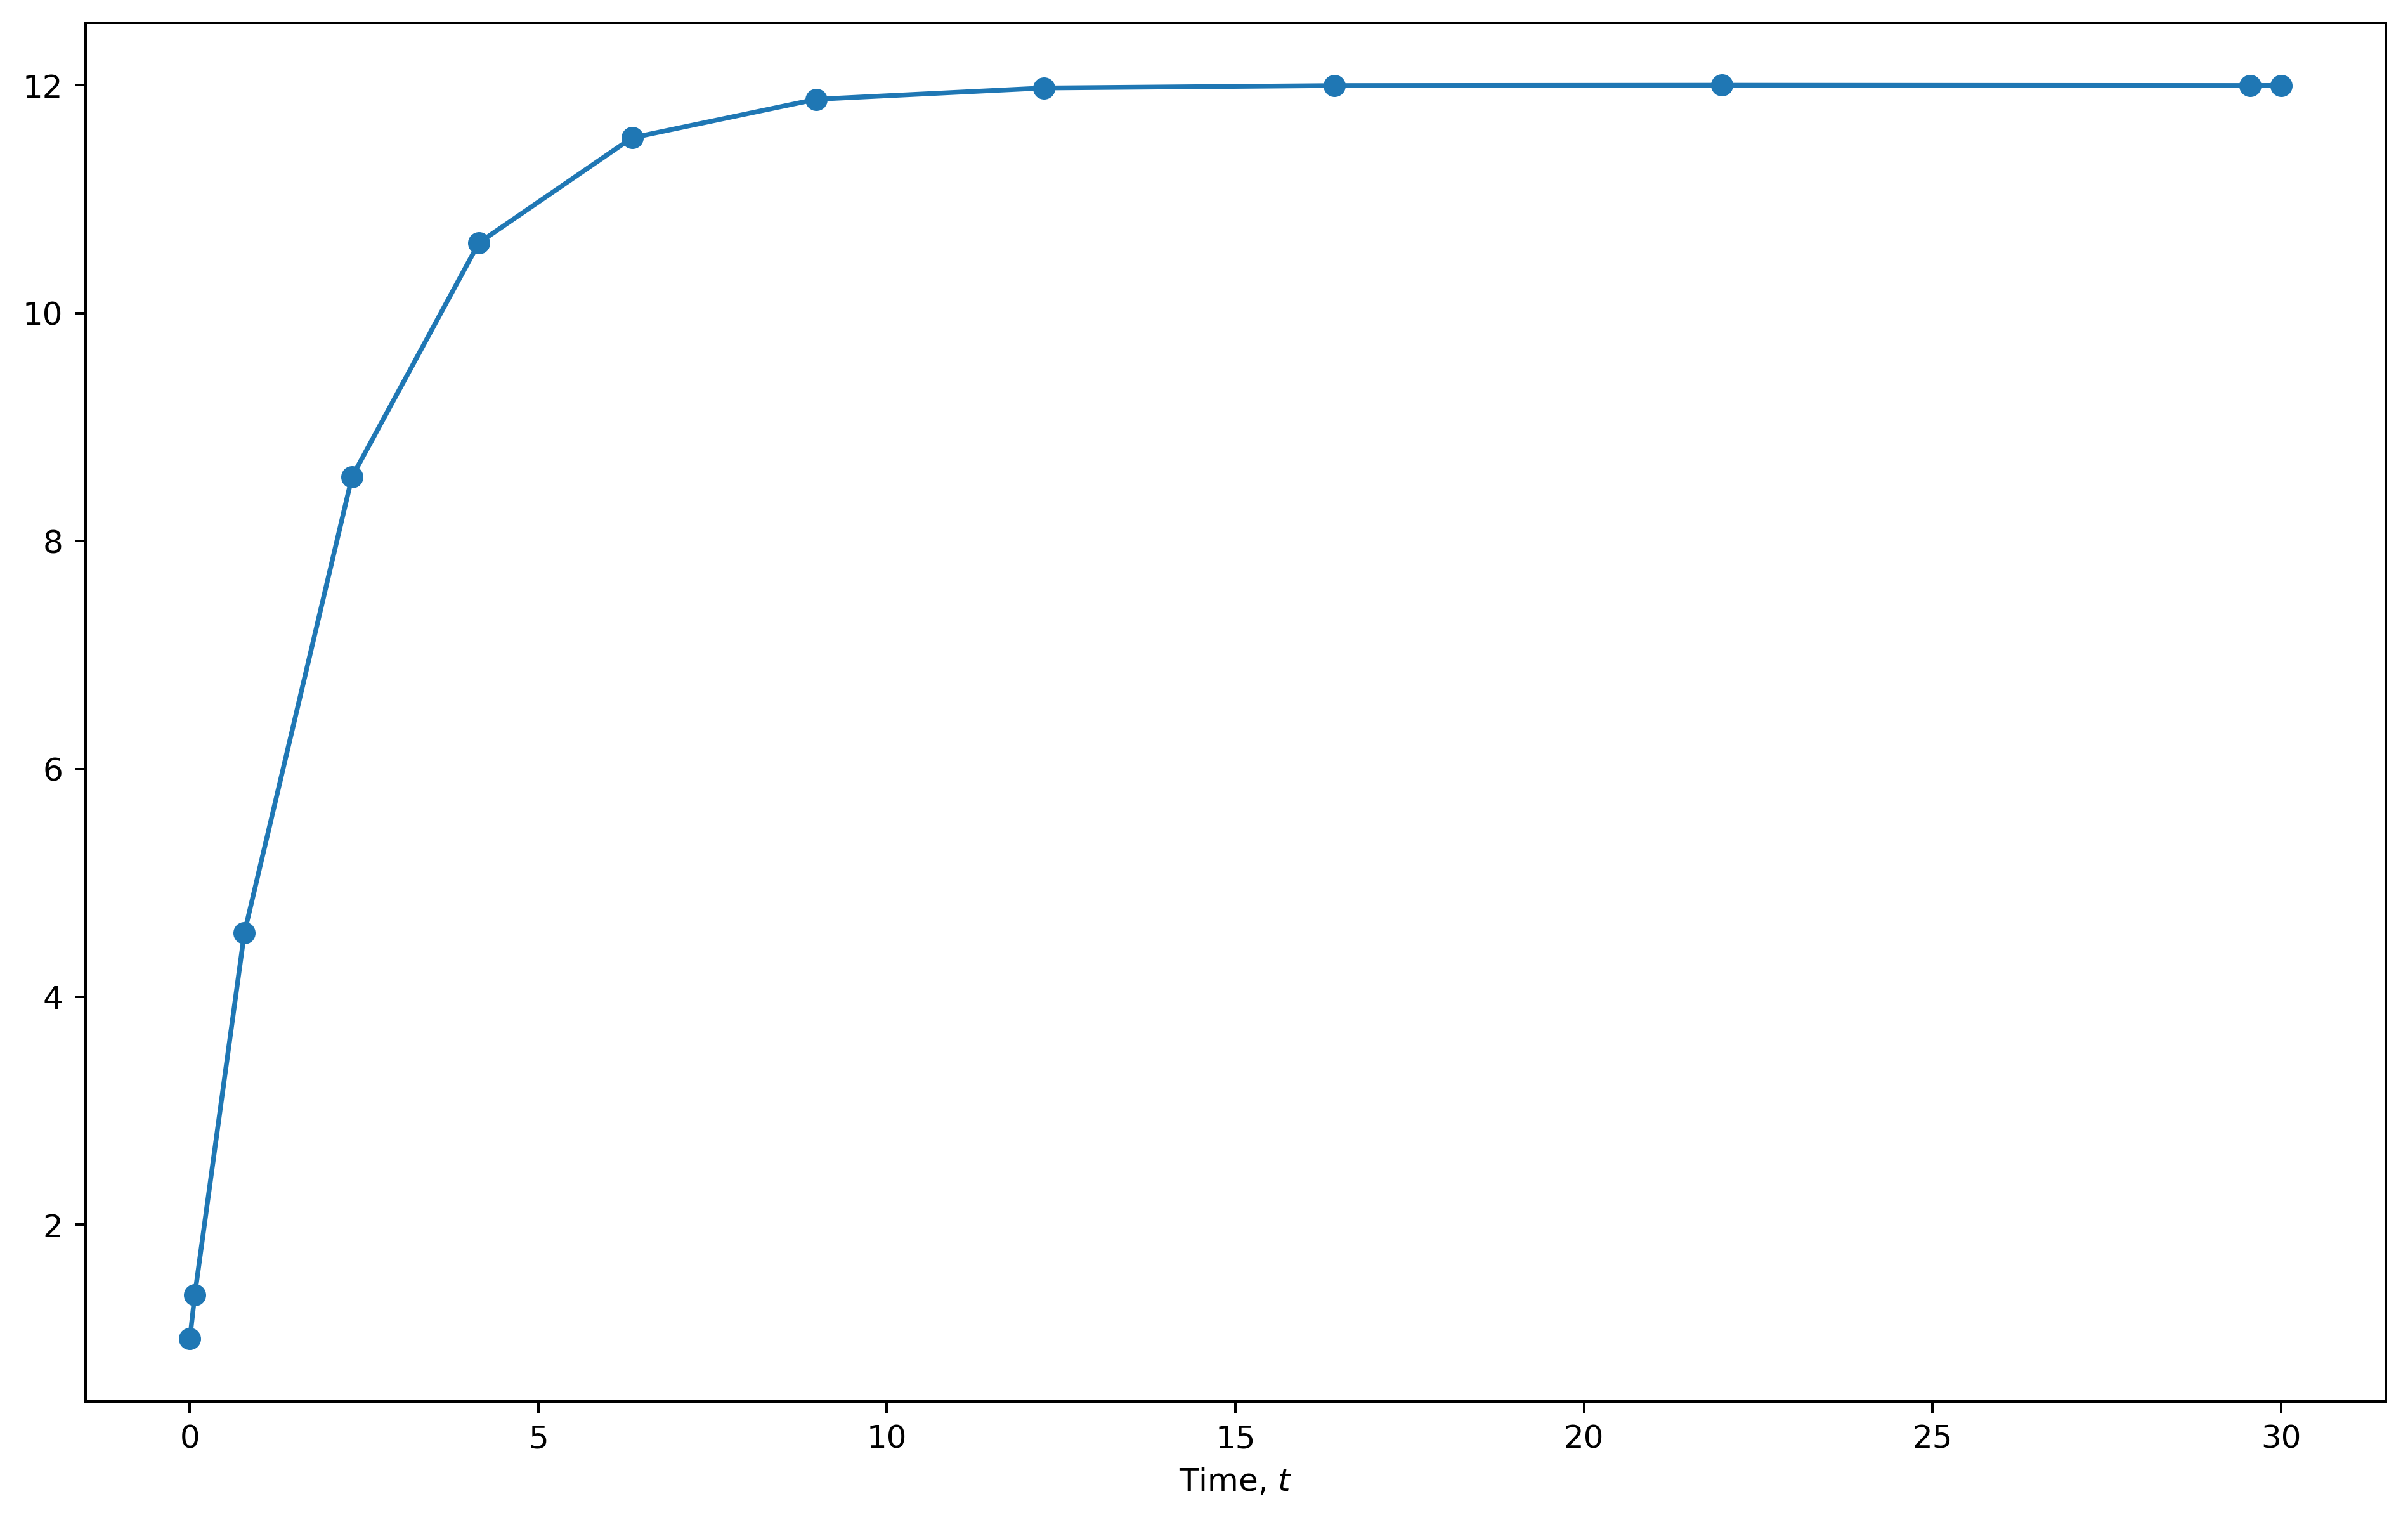

In [4]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=360)
ax.plot(sol.t, sol.y.T, 'o-')
ax.set_xlabel("Time, $t$")

In [5]:
neat_ts = np.linspace(*tspan, 15)
raw_data = sol.sol(neat_ts)
data = raw_data + np.random.randn(15)*0.075
data.shape

(1, 15)

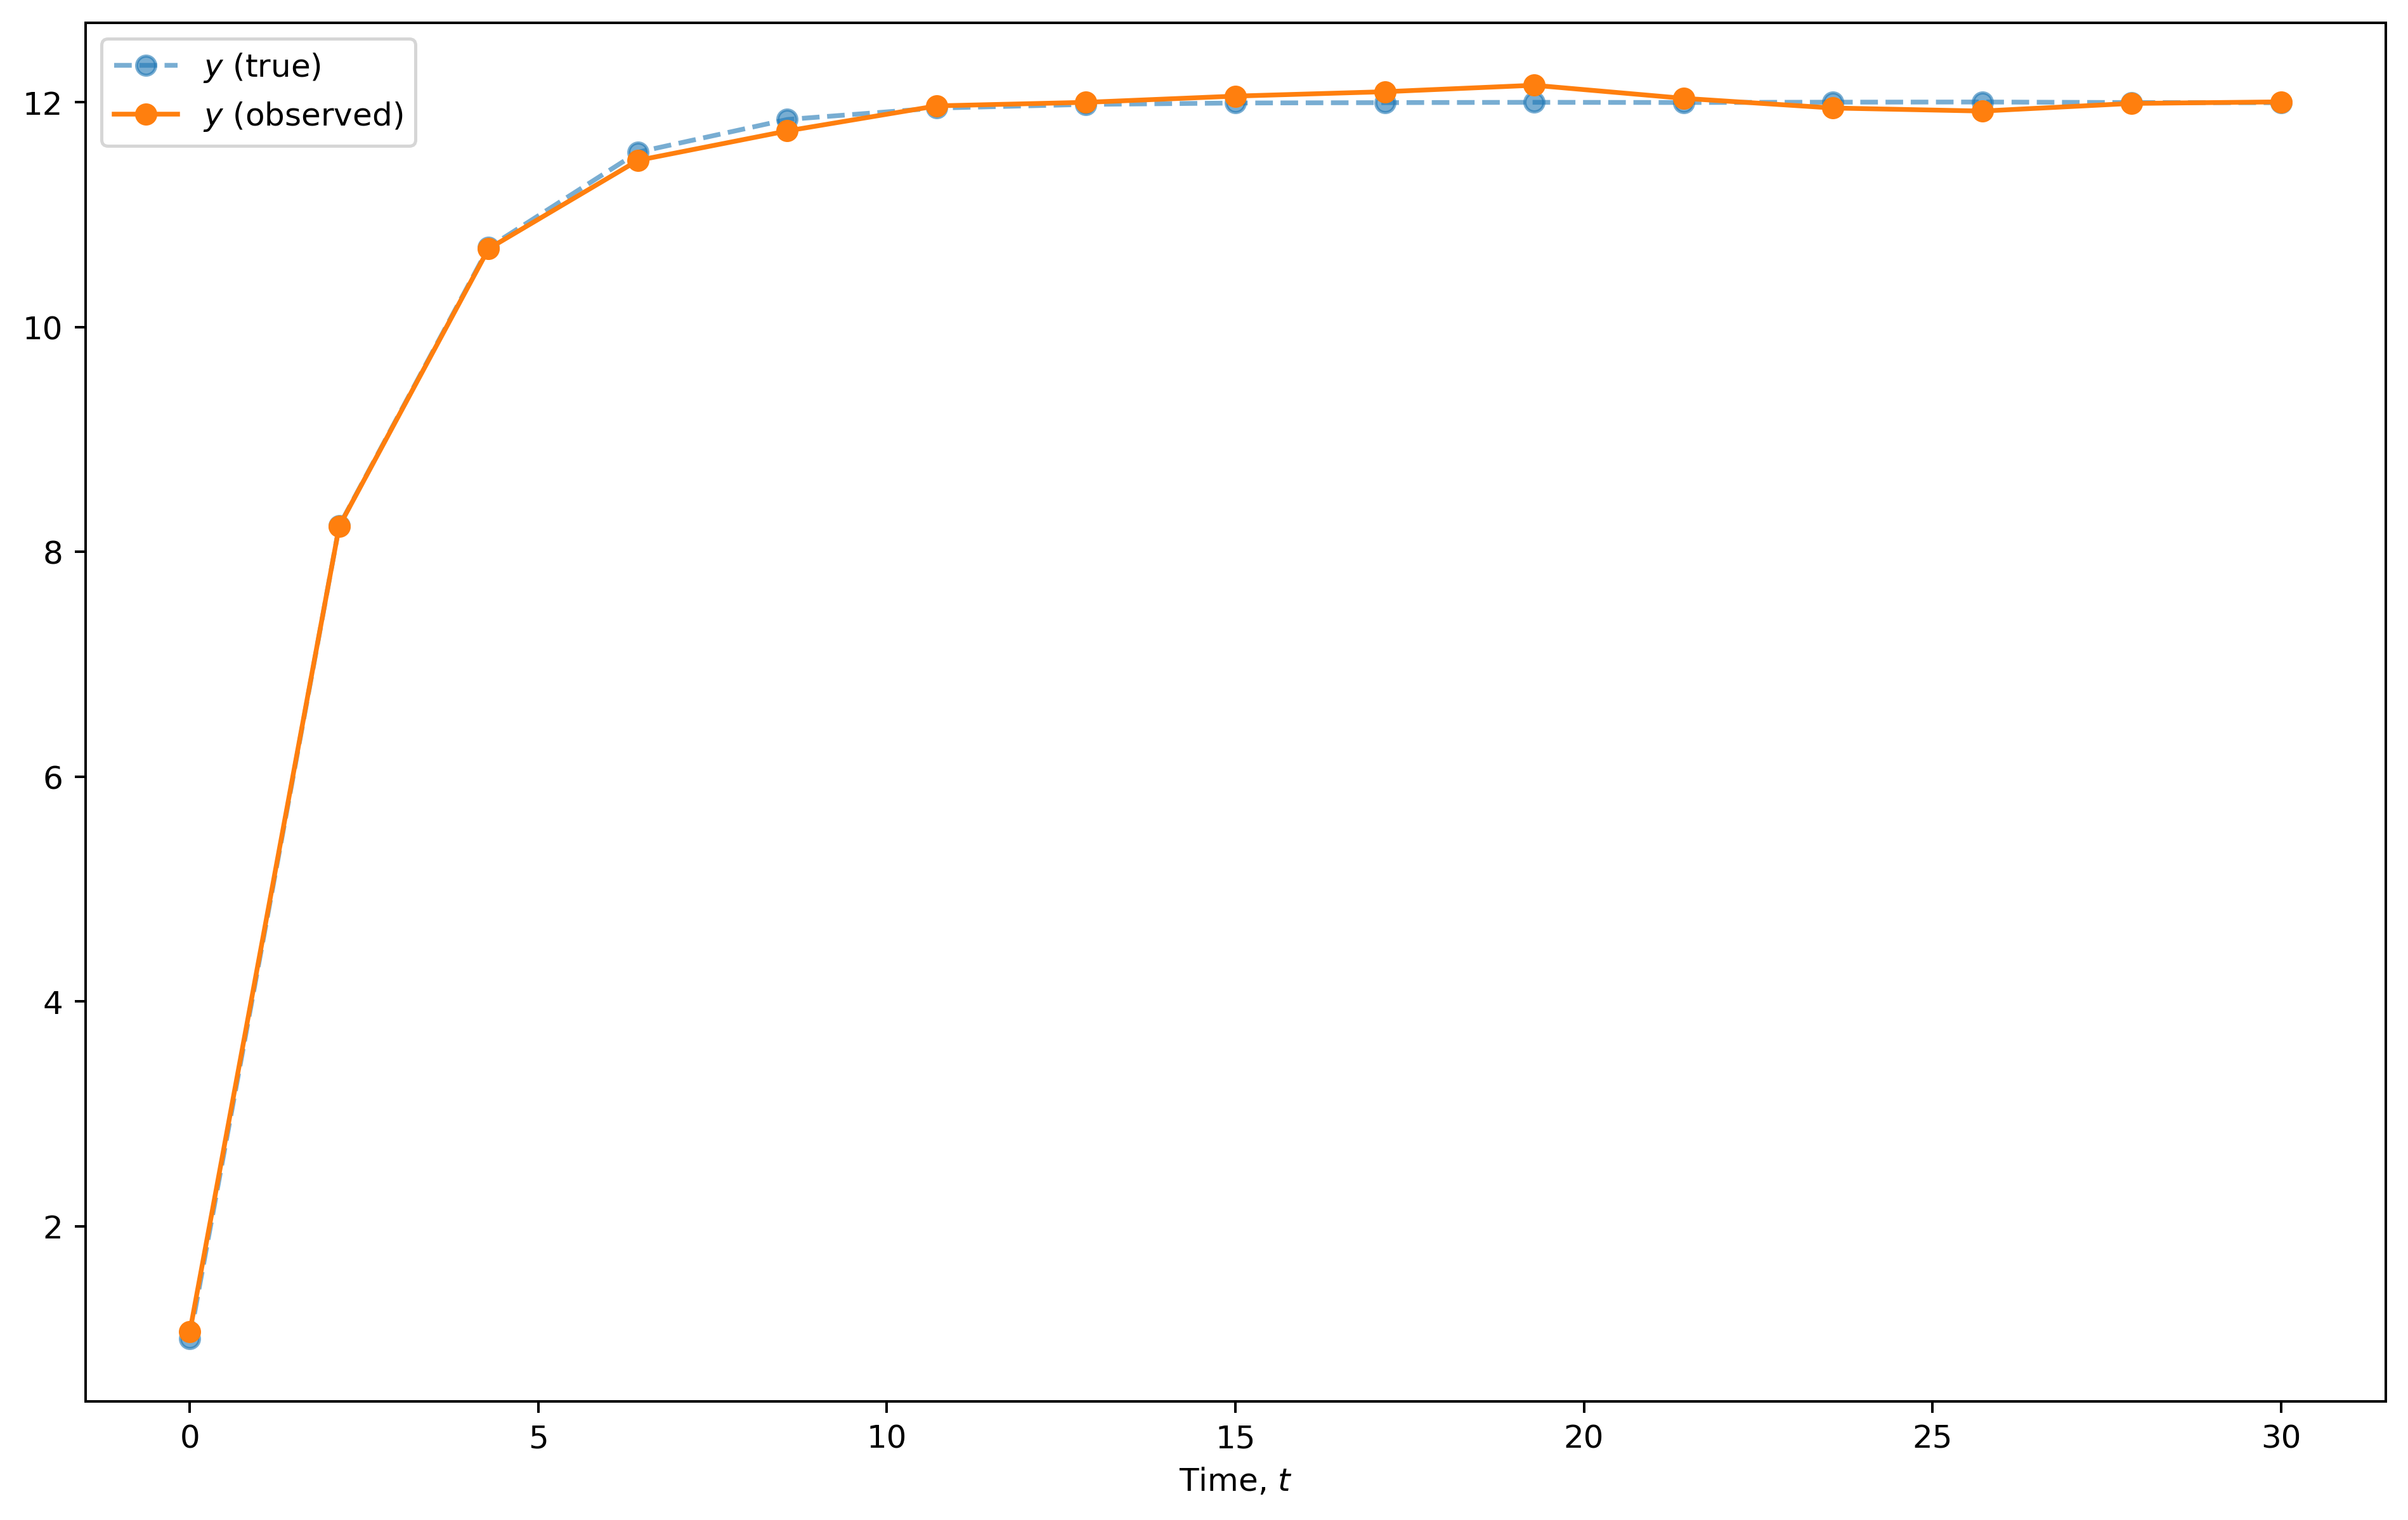

In [6]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=360)
ax.plot(neat_ts, raw_data.T, 'o--', alpha=0.6, label="$y$ (true)")
ax.plot(neat_ts, data.T, 'o-', label="$y$ (observed)")
ax.set_xlabel('Time, $t$')
ax.legend()

In [7]:
data_pd = np.array([[i] for i in list(data.flatten())])
config = {
    "grid_size": 100,
    "basis_number": 50,
    "model_form": {
        "state": 1,
        "parameters": 3
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_pd, "t": neat_ts},
    "observation_vector": [0],
    "weightings":[
        [1]*2,
        [1]*len(neat_ts)
    ],
    "regularisation_value": [0, 0, 0],
}

In [8]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha])
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [9]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getdx = ca.Function('getdx', [solver_setup['x']], [model.xdash])
getc = ca.Function('getc', [solver_setup['x']], model.cs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
f_ex = ca.Function('f_ex', [solver_setup['x'], objective.rho, objective.alpha], [objective.objective])

In [10]:
p0 = [1, 1, 1]
c0 = np.ones(config['basis_number']*1)
x0 = np.hstack([*c0, p0])
lbx = [-float('inf')]*(config['basis_number']*1) + [0]*len(config['regularisation_value'])

In [11]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, (np.log10(p)+6)*1e-5], lbx=lbx))
#     solutions.append(solver(x0=xguess, p=[p, 0], lbx=lbx))
    xguess = np.array(solutions[-1]['x']).flatten()
#     xguess += np.random.randn()*np.mean(xguess)/40


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

   2  1.1183289e-05 0.00e+00 1.30e-06  -3.8 2.51e-02    -  1.00e+00 1.00e+00f  1
   3  8.4994472e-06 0.00e+00 7.12e-08  -8.6 4.54e-02    -  1.00e+00 1.00e+00f  1
   4  7.7006828e-06 0.00e+00 5.90e-08  -8.6 2.37e-02    -  1.00e+00 1.00e+00f  1
   5  7.4726624e-06 0.00e+00 3.85e-09  -8.6 9.59e-03    -  1.00e+00 1.00e+00f  1
   6  7.4259502e-06 0.00e+00 1.75e-10  -8.6 2.28e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   7.4259502480040104e-06    7.4259502480040104e-06
Dual infeasibility......:   1.7483246311535585e-10    1.7483246311535585e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.3968537119178958e-09    5.3968537119178958e-09
Overall NLP error.......:   5.3968537119178958e-09    5.3968537119178958e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations          

  13  3.9257579e-05 0.00e+00 8.95e-09  -9.0 3.07e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   3.9257578917454279e-05    3.9257578917454279e-05
Dual infeasibility......:   8.9503616909451800e-09    8.9503616909451800e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2213781906683479e-10    9.2213781906683479e-10
Overall NLP error.......:   8.9503616909451800e-09    8.9503616909451800e-09


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 13
Total CPU secs in IPOPT (w/o

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6188464e-04 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

Overall NLP error.......:   2.5059320640346801e-09    2.5059320640346801e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 185.00us ( 23.12us) 186.35us ( 23.29us)         8
    nlp_grad  |  45.00us ( 45.00us)  44.17us ( 44.17us)         1
  nlp_grad_f  | 419.00us ( 46.56us) 421.13us ( 46.79us)         9
  nlp_hess_l  |   8.48ms (  1.21ms)   8.52ms (  1.22ms)         7
       total  |  14.24ms ( 14

   0  5.0053162e-04 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0824817e-03 0.00e+00 2.41e-02  -1.0 1.83e-01    -  9.79e-01 1.00e+00f  1
   2  8.1023352e-04 0.00e+00 3.57e-03  -2.5 2.00e-01    -  1.00e+00 1.00e+00f  1
   3  6.8412087e-04 0.00e+00 8.06e-04  -3.8 5.84e-02  -2.0 1.00e+00 1.00e+00f  1
   4  5.8527450e-04 0.00e+00 1.30e-03  -5.7 7.56e-02  -2.5 1.00e+00 1.00e+00f  1
   5  5.3151120e-04 0.00e+00 7.52e-04  -5.7 1.07e-01  -3.0 1.00e+00 1.00e+00f  1
   6  5.0047136e-04 0.00e+00 6.75e-04  -5.7 2.22e-01    -  1.00e+00 1.00e+00f  1
   7  5.0039159e-04 0.00e+00 5.44e-09  -5.7 7.63e-04    -  1.00e+00 1.00e+00f  1
   8  5.0039110e-04 0.00e+00 2.37e-08  -8.6 4.46e-04    -  1.00e+00 1.00e+00f  1
   9  5.0039110e-04 0.00e+00 3.70e-14  -9.0 4.27e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   5.0039110166458277e-04    5.0039110166458277e-04
Dual infeasi

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 166.00us ( 20.75us) 166.82us ( 20.85us)         8
    nlp_grad  |  46.00us ( 46.00us)  45.54us ( 45.54us)         1
  nlp_grad_f  | 394.00us ( 43.78us) 395.36us ( 43.93us)         9
  nlp_hess_l  |   8.41ms (  1.20ms)   8.41ms (  1.20ms)         7
       total  |  13.83ms ( 13.83ms)  13.32ms ( 13.32ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number

   0  1.5295038e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.8397634e-03 0.00e+00 1.60e-01  -1.0 1.79e-01    -  9.89e-01 1.00e+00f  1
   2  1.8124286e-03 0.00e+00 6.69e-02  -2.5 9.55e-02  -2.0 1.00e+00 1.00e+00f  1
   3  1.6388180e-03 0.00e+00 2.38e-03  -2.5 2.66e-02  -1.6 1.00e+00 1.00e+00f  1
   4  1.5370184e-03 0.00e+00 3.37e-03  -3.8 3.81e-02  -2.1 1.00e+00 1.00e+00f  1
   5  1.5273394e-03 0.00e+00 1.92e-04  -3.8 1.52e-02  -2.5 1.00e+00 1.00e+00f  1
   6  1.5269688e-03 0.00e+00 1.72e-05  -5.7 3.32e-03    -  1.00e+00 1.00e+00f  1
   7  1.5269688e-03 0.00e+00 6.93e-10  -8.6 1.17e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.5269688242760190e-03    1.5269688242760190e-03
Dual infeasibility......:   6.9252143227916296e-10    6.9252143227916296e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   0  2.9175354e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.8476913e-03 0.00e+00 3.47e-01  -1.0 1.50e-01    -  1.00e+00 1.00e+00f  1
   2  5.2442136e-03 0.00e+00 9.81e-03  -1.7 8.55e-03   0.0 1.00e+00 1.00e+00f  1
   3  4.4822333e-03 0.00e+00 1.61e-02  -3.8 1.70e-02  -0.5 1.00e+00 1.00e+00f  1
   4  3.8037983e-03 0.00e+00 1.29e-02  -3.8 3.11e-02  -1.0 1.00e+00 1.00e+00f  1
   5  3.1745843e-03 0.00e+00 1.66e-02  -3.8 4.64e-02  -1.4 1.00e+00 1.00e+00f  1
   6  2.9319674e-03 0.00e+00 9.48e-03  -3.8 4.01e-02  -1.9 1.00e+00 1.00e+00f  1
   7  2.9081519e-03 0.00e+00 1.11e-03  -3.8 1.50e-02  -2.4 1.00e+00 1.00e+00f  1
   8  2.9076113e-03 0.00e+00 4.16e-05  -5.7 2.64e-03    -  1.00e+00 1.00e+00f  1
   9  2.9076113e-03 0.00e+00 2.21e-11  -5.7 7.02e-07    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9076113e-03 0.00e+00 5.17e-10  -8.6 5.81e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   3  4.3819211e-03 0.00e+00 1.14e+00  -2.5 1.47e-01    -  1.00e+00 1.00e+00f  1
   4  4.1834515e-03 0.00e+00 6.46e-04  -2.5 1.94e-03  -0.5 1.00e+00 1.00e+00f  1
   5  4.1729531e-03 0.00e+00 1.57e-03  -3.8 8.81e-03    -  1.00e+00 1.00e+00f  1
   6  4.1729503e-03 0.00e+00 2.74e-08  -3.8 2.12e-05    -  1.00e+00 1.00e+00f  1
   7  4.1729309e-03 0.00e+00 6.60e-06  -5.7 3.73e-04    -  1.00e+00 1.00e+00f  1
   8  4.1729309e-03 0.00e+00 1.00e-09  -8.6 4.58e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   4.1729309173339467e-03    4.1729309173339467e-03
Dual infeasibility......:   1.0046433904242497e-09    1.0046433904242497e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088878461835729e-09    2.5088878461835729e-09
Overall NLP error.......:   2.5088878461835729e-09    2.5088878461835729e-09


Number of objective functi

   8  4.7794946e-03 0.00e+00 1.88e-11  -5.7 6.22e-08    -  1.00e+00 1.00e+00f  1
   9  4.7794946e-03 0.00e+00 4.68e-09  -8.6 4.45e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   4.7794945602716143e-03    4.7794945602716143e-03
Dual infeasibility......:   4.6821397797711625e-09    4.6821397797711625e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5085047048309122e-09    2.5085047048309122e-09
Overall NLP error.......:   4.6821397797711625e-09    4.6821397797711625e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number

   9  4.9547711e-03 0.00e+00 3.56e-07  -8.6 1.81e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9547711e-03 0.00e+00 2.67e-07  -8.6 5.30e-10    -  1.00e+00 2.50e-01f  3
  11  4.9547711e-03 0.00e+00 2.00e-07  -8.6 3.98e-10    -  1.00e+00 2.50e-01f  3
  12  4.9547711e-03 0.00e+00 1.50e-07  -8.6 2.98e-10    -  1.00e+00 2.50e-01f  3
  13  4.9547711e-03 0.00e+00 1.41e-07  -8.6 2.24e-10    -  1.00e+00 6.25e-02f  5
  14  4.9547711e-03 0.00e+00 1.41e-07  -8.6 2.10e-10    -  1.00e+00 7.63e-06f 18
  15  4.9547711e-03 0.00e+00 1.41e-07  -8.6 2.10e-10    -  1.00e+00 1.53e-05f 17
  16  4.9547711e-03 0.00e+00 1.41e-07  -8.6 2.10e-10    -  1.00e+00 1.53e-05f 17
  17  4.9547711e-03 0.00e+00 1.41e-07  -8.6 2.10e-10    -  1.00e+00 7.63e-06f 18
  18  4.9547711e-03 0.00e+00 1.41e-07  -8.6 2.10e-10    -  1.00e+00 7.63e-06f 18
  19  4.9547711e-03 0.00e+00 1.41e-07  -8.6 2.10e-10    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr 

   0  5.0243901e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.2455544e-03 0.00e+00 1.54e+01  -1.0 1.49e-01    -  1.00e+00 5.00e-01f  2
   2  5.7531656e-03 0.00e+00 3.29e-02  -1.0 3.29e-04   2.0 1.00e+00 1.00e+00f  1
   3  5.2977330e-03 0.00e+00 1.05e+01  -2.5 6.13e-02    -  1.00e+00 1.00e+00f  1
   4  5.0554508e-03 0.00e+00 7.53e-03  -2.5 2.26e-04   1.5 1.00e+00 1.00e+00f  1
   5  5.0247608e-03 0.00e+00 4.52e-01  -3.8 1.24e-02    -  1.00e+00 1.00e+00f  1
   6  5.0243002e-03 0.00e+00 1.42e-04  -3.8 1.28e-05   1.0 1.00e+00 1.00e+00f  1
   7  5.0241630e-03 0.00e+00 2.87e-03  -5.7 1.01e-03    -  1.00e+00 1.00e+00f  1
   8  5.0241630e-03 0.00e+00 3.34e-09  -5.7 1.15e-06    -  1.00e+00 1.00e+00f  1
   9  5.0241630e-03 0.00e+00 5.39e-08  -8.6 4.44e-06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0241630e-03 0.00e+00 5.37e-08  -8.6 6.46e-12    -  1.00e+00 3.91e-03f  9
  11  5.0241630e-03 0.00e+00

Dual infeasibility......:   3.9834196507442398e-12    3.9834196507442398e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.5059035596800618e-09
Overall NLP error.......:   2.5059035596800618e-09    2.5059035596800618e-09


Number of objective function evaluations             = 23
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.007
Total CPU secs in NLP function evaluations           =      0.014

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 498.00us ( 21.65us) 498.31us ( 21.67us)    

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.1721808e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

   8  5.2651767e-03 0.00e+00 5.96e-05  -5.7 1.61e-05   0.6 1.00e+00 1.00e+00f  1
   9  5.2651766e-03 0.00e+00 2.30e-05  -5.7 2.19e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2651766e-03 0.00e+00 1.15e-05  -5.7 9.71e-09    -  1.00e+00 5.00e-01f  2
  11  5.2651766e-03 0.00e+00 1.31e-06  -8.6 4.44e-06    -  1.00e+00 1.00e+00f  1
  12  5.2651766e-03 0.00e+00 1.23e-06  -8.6 4.51e-12    -  1.00e+00 6.25e-02f  5
  13  5.2651766e-03 0.00e+00 1.22e-06  -8.6 4.23e-12    -  1.00e+00 9.77e-04f 11
  14  5.2651766e-03 0.00e+00 1.22e-06  -8.6 4.23e-12    -  1.00e+00 7.81e-03f  8
  15  5.2651766e-03 0.00e+00 1.22e-06  -8.6 4.19e-12    -  1.00e+00 1.53e-05f 17
  16  5.2651766e-03 0.00e+00 1.22e-06  -8.6 4.19e-12    -  1.00e+00 1.53e-05f 17
  17  5.2651766e-03 0.00e+00 1.22e-06  -8.6 4.19e-12    -  1.00e+00 1.53e-05f 17
  18  5.2651766e-03 0.00e+00 1.22e-06  -8.6 4.19e-12    -  1.00e+00 1.53e-05f 17
  19  5.2651766e-03 0.00e+00

   8  5.4001322e-03 0.00e+00 5.97e-04  -5.7 6.22e-05   0.6 1.00e+00 1.00e+00f  1
   9  5.3968477e-03 0.00e+00 5.47e+00  -5.7 5.93e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3956369e-03 0.00e+00 4.98e-06  -5.7 4.03e-06   0.1 1.00e+00 1.00e+00f  1
  11  5.3956369e-03 0.00e+00 5.01e-06  -8.6 5.81e-06    -  1.00e+00 1.00e+00f  1
  12  5.3956369e-03 0.00e+00 4.69e-06  -8.6 2.48e-10    -  1.00e+00 6.25e-02f  5
  13  5.3956369e-03 0.00e+00 2.35e-06  -8.6 2.33e-10    -  1.00e+00 5.00e-01f  2
  14  5.3956369e-03 0.00e+00 2.20e-06  -8.6 1.16e-10    -  1.00e+00 6.25e-02f  5
  15  5.3956369e-03 0.00e+00 1.65e-06  -8.6 1.09e-10    -  1.00e+00 2.50e-01f  3
  16  5.3956369e-03 0.00e+00 1.64e-06  -8.6 8.19e-11    -  1.00e+00 3.91e-03f  9
  17  5.3956369e-03 0.00e+00 1.64e-06  -8.6 8.15e-11    -  1.00e+00 1.91e-06f 20
  18  5.3956369e-03 0.00e+00 1.64e-06  -8.6 8.15e-11    -  1.00e+00 1.91e-06f 20
  19  5.3956369e-03 0.00e+00

  18  5.6381987e-03 0.00e+00 3.81e-06  -8.6 2.30e-10    -  1.00e+00 4.77e-07f 22
  19  5.6381987e-03 0.00e+00 3.81e-06  -8.6 2.30e-10    -  1.00e+00 4.77e-07f 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.6381987e-03 0.00e+00 3.41e-09  -8.6 2.30e-10    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   5.6381987046410760e-03    5.6381987046410760e-03
Dual infeasibility......:   3.4126454061821039e-09    3.4126454061821039e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.5059035596800618e-09
Overall NLP error.......:   3.4126454061821039e-09    3.4126454061821039e-09


Number of objective function evaluations             = 226
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 0
Number of ine

    nlp_grad  |  71.00us ( 71.00us)  70.37us ( 70.37us)         1
  nlp_grad_f  |   1.11ms ( 46.08us)   1.28ms ( 53.35us)        24
  nlp_hess_l  |  26.24ms (  1.19ms)  26.25ms (  1.19ms)        22
       total  |  49.58ms ( 49.58ms)  48.65ms ( 48.65ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequali

   2  7.2340146e-03 0.00e+00 2.41e-02  -1.0 1.01e-04   2.0 1.00e+00 1.00e+00f  1
   3  7.2287717e-03 0.00e+00 8.64e+00  -2.5 4.22e-03    -  1.00e+00 5.00e-01f  2
   4  7.2285277e-03 0.00e+00 8.83e-05  -2.5 2.65e-06   1.5 1.00e+00 1.00e+00f  1
   5  7.2248675e-03 0.00e+00 3.25e+01  -3.8 8.28e-03    -  1.00e+00 5.00e-01f  2
   6  7.2213446e-03 0.00e+00 3.49e-04  -3.8 1.41e-05   1.0 1.00e+00 1.00e+00f  1
   7  7.2196637e-03 0.00e+00 9.42e+00  -5.7 4.46e-03    -  1.00e+00 5.00e-01f  2
   8  7.2193532e-03 0.00e+00 1.22e-03  -5.7 2.48e-05   0.6 1.00e+00 1.00e+00f  1
   9  7.2189890e-03 0.00e+00 9.20e+00  -5.7 2.21e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.2187076e-03 0.00e+00 8.50e-07  -5.7 5.50e-07   0.1 1.00e+00 1.00e+00f  1
  11  7.2187076e-03 0.00e+00 4.25e-05  -8.6 4.63e-06    -  1.00e+00 1.00e+00f  1
  12  7.2187076e-03 0.00e+00 3.72e-05  -8.6 5.71e-11    -  1.00e+00 1.25e-01f  4
  13  7.2187076e-03 0.00e+00

In [12]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

Text(0, 0.5, 'Model Error')

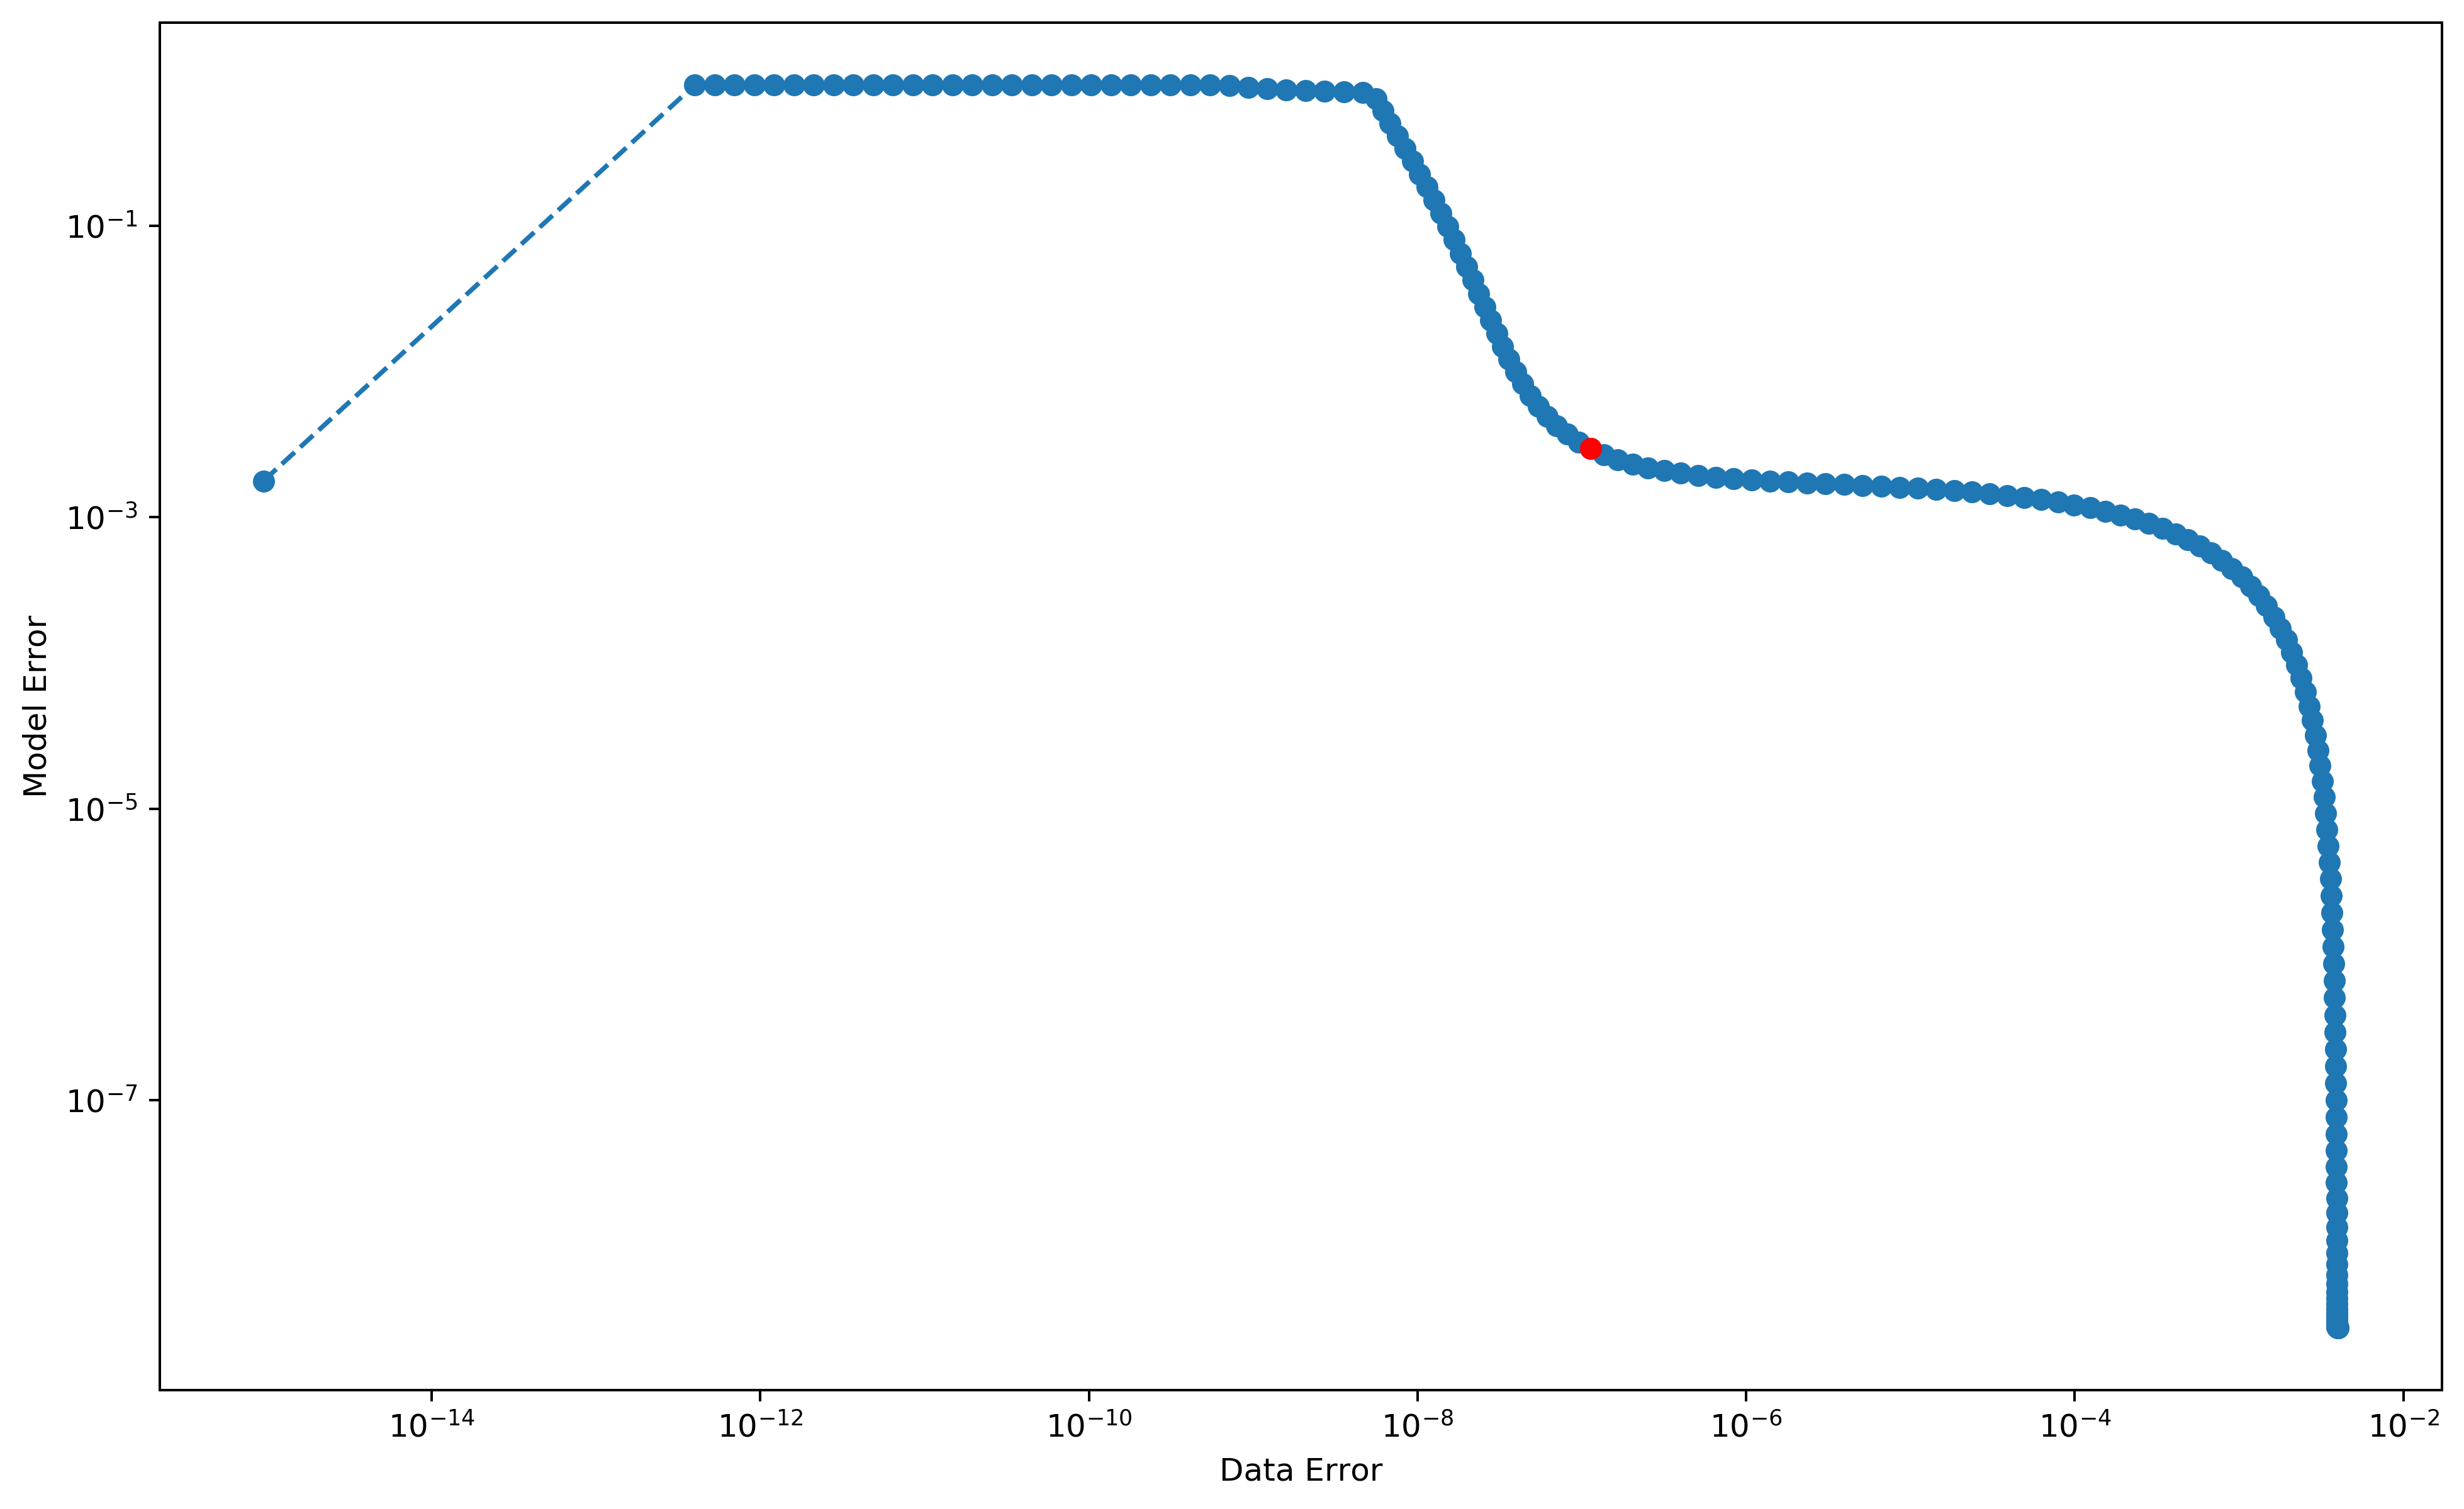

In [13]:
idx = 65
fig, ax=plt.subplots(figsize=[13, 8], dpi=360)
ax.loglog(*fsvals.T, 'o--')
ax.loglog(*fsvals[idx], 'ro')
ax.set_xlabel("Data Error")
ax.set_ylabel("Model Error")

Text(0, 0.5, '$x_1$')

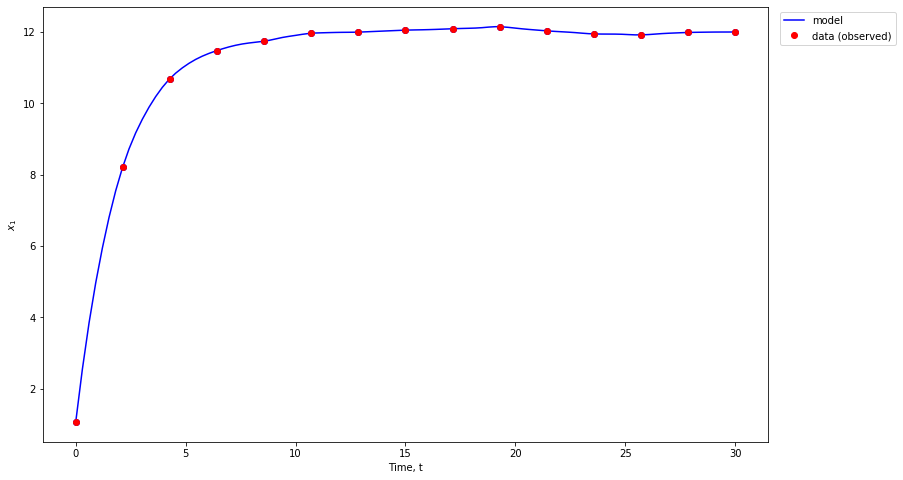

In [14]:
idx = 65
plt.plot(model.observation_times, getx(solutions[idx]['x']), 'b-', label='model')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])).flatten()).T, 'bo')#, label='model (collocation)')
plt.plot(neat_ts, data.T, 'ro', label='data (observed)')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("Time, t")
plt.ylabel("$x_1$")

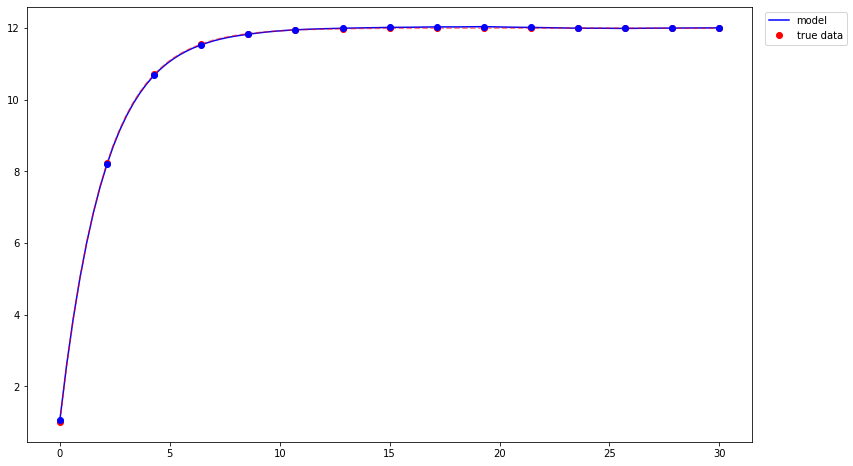

In [15]:
idx = 115
plt.plot(model.observation_times, getx(solutions[idx]['x']), 'b-', label='model')
plt.plot(model.observation_times, sol.sol(model.observation_times).T, 'r--', alpha=0.5)
plt.plot(neat_ts, sol.sol(neat_ts)[0].T, 'ro', label='true data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])).flatten()).T, 'bo')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

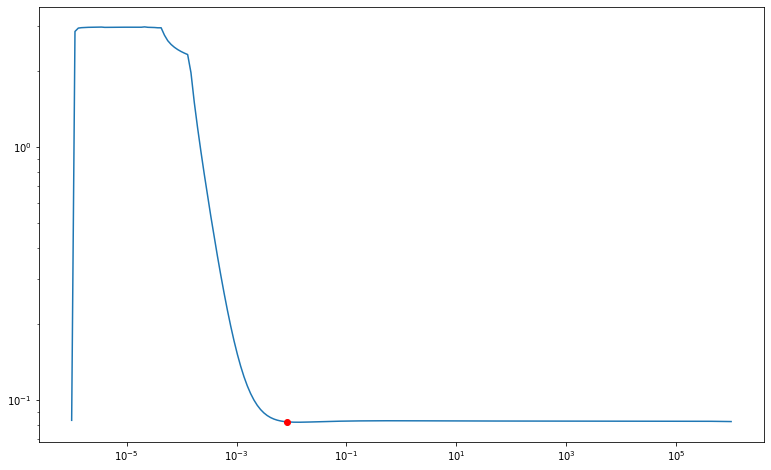

In [16]:
pwrongness = lambda idx: np.sum(((np.array(p_true) - np.array(getp(solutions[idx]['x'])))/np.array(p_true))**2)
perr = [pwrongness(i) for i in range(200)]
plt.loglog(prange, perr)
idx = 65
plt.loglog(prange[idx], perr[idx], 'ro')

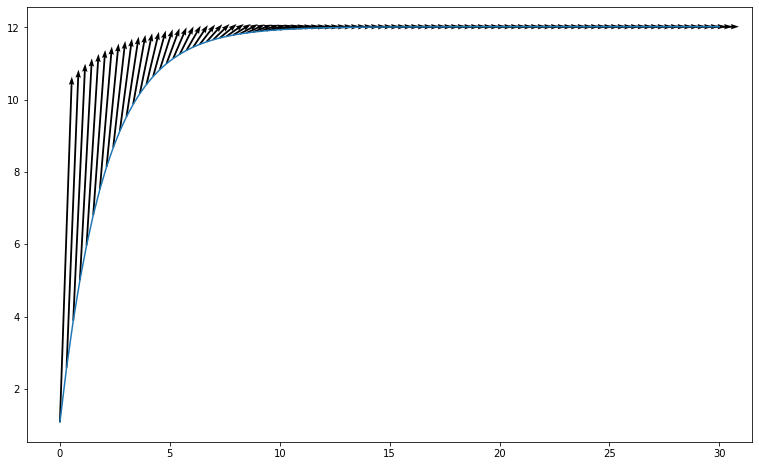

In [17]:
idx = 199
plt.plot(model.observation_times, getx(solutions[idx]['x']))
plt.quiver(model.observation_times, np.array(getx(solutions[idx]['x'])).flatten(),
           np.gradient(model.observation_times), np.array(getdx(solutions[idx]['x'])), 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)

In [18]:
fff12 = ca.Function('fff12', [solver_setup['x'], objective.rho], [objective.obj_1 + objective.rho*objective.obj_2])

In [19]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.ps),
}
myinf = float('inf')
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup)

In [32]:
idx = 115
rho = prange[idx]
pref = getp(solutions[idx]['x'])

pvals = np.logspace(-1, 0.5, num=100)
profile = []
profile_r = []
for pval in pvals:
    lbg = np.array([pval, -myinf, -myinf])
    ubg = np.array([pval, myinf, myinf])
    profile.append(profiler(x0=solutions[idx]['x'], p=[rho, 0], lbg=lbg, ubg=ubg, lbx=lbx))
    profile_r.append(profiler(x0=solutions[idx]['x'], p=[rho, (np.log10(p)+6)*1e-5], lbg=lbg, ubg=ubg, lbx=lbx))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

       nlp_f  | 224.00us ( 17.23us) 225.48us ( 17.34us)        13
       nlp_g  |  36.00us (  2.77us)  31.36us (  2.41us)        13
    nlp_grad  |  52.00us ( 52.00us)  52.41us ( 52.41us)         1
  nlp_grad_f  | 628.00us ( 44.86us) 628.50us ( 44.89us)        14
  nlp_hess_l  |  13.53ms (  1.13ms)  13.54ms (  1.13ms)        12
   nlp_jac_g  |  35.00us (  2.50us)  34.85us (  2.49us)        14
       total  |  21.30ms ( 21.30ms)  20.72ms ( 20.72ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
          

   4  2.0974758e-01 0.00e+00 4.31e+00  -1.0 1.26e+01    -  8.36e-01 1.00e+00f  1
   5  2.0621998e-02 0.00e+00 8.27e-01  -1.0 9.38e+00    -  1.00e+00 1.00e+00f  1
   6  3.4116282e-03 0.00e+00 3.44e-01  -1.7 3.84e+00    -  1.00e+00 1.00e+00f  1
   7  3.3590551e-03 0.00e+00 2.60e-02  -1.7 1.33e+00    -  1.00e+00 1.00e+00f  1
   8  3.0642992e-03 0.00e+00 1.55e-02  -3.8 7.02e-01    -  1.00e+00 1.00e+00f  1
   9  3.0642165e-03 0.00e+00 1.78e-06  -3.8 4.16e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 1.01e-06  -5.7 5.81e-03    -  1.00e+00 1.00e+00f  1
  11  3.0641956e-03 0.00e+00 1.56e-10  -8.6 7.16e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212835897e-03    3.0641956212835897e-03
Dual infeasibility......:   1.5582492830963473e-10    1.5582492830963473e-10
Constraint viol

Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.006
Total CPU secs in NLP function evaluations           =      0.009

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 215.00us ( 19.55us) 220.43us ( 20.04us)        11
       nlp_g  |  30.00us (  2.73us)  27.63us (  2.51us)        11
    nlp_grad  |  48.00us ( 48.00us)  47.89us ( 47.89us)         1
  nlp_grad_f  | 660.00us ( 55.00us) 701.66us ( 58.47us)        12
  nlp_hess_l  |  11.55ms (  1.15ms)  11.55ms (  1.16ms)        10
   nlp_jac_g  |  31.00us (  2.58us)  31.26us (  2.60us)        12
       total  |  20.24ms ( 20.24ms)  19.51ms ( 19.51ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documenta

   1  7.3199353e+01 2.22e-16 5.53e+02  -1.0 2.24e+00    -  6.65e-01 1.00e+00h  1
   2  3.3103915e+00 0.00e+00 2.48e+01  -1.0 7.11e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.4329354e+00 0.00e+00 4.01e+00  -1.0 1.57e+01    -  1.72e-01 1.00e+00f  1
   4  2.9932203e-01 0.00e+00 3.94e+00  -1.0 7.77e+00    -  1.00e+00 1.00e+00f  1
   5  1.2539478e-01 0.00e+00 6.30e-01  -1.0 3.81e+00    -  1.00e+00 1.00e+00f  1
   6  1.0552847e-01 0.00e+00 3.75e-01  -1.7 2.88e+00    -  1.00e+00 1.00e+00f  1
   7  1.0565648e-01 0.00e+00 2.96e-03  -1.7 2.26e-01    -  1.00e+00 1.00e+00f  1
   8  1.0534963e-01 0.00e+00 7.03e-03  -3.8 4.28e-01    -  1.00e+00 1.00e+00f  1
   9  1.0534959e-01 0.00e+00 5.70e-07  -3.8 1.75e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0534957e-01 0.00e+00 4.05e-07  -5.7 3.22e-03    -  1.00e+00 1.00e+00f  1
  11  1.0534957e-01 0.00e+00 6.30e-11  -8.6 3.99e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   9  8.1952403e-02 0.00e+00 4.07e-07  -5.7 2.94e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.1952403e-02 0.00e+00 6.14e-11  -8.6 3.63e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   8.1952402875176897e-02    8.1952402875176897e-02
Dual infeasibility......:   6.1379233338930395e-11    6.1379233338930395e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5087508901195215e-09    2.5087508901195215e-09
Overall NLP error.......:   2.5087508901195215e-09    2.5087508901195215e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobi

   2  2.8979122e+00 0.00e+00 2.06e+01  -1.0 6.60e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.0589000e+00 0.00e+00 6.51e+00  -1.0 1.62e+01    -  1.84e-01 5.00e-01f  2
   4  1.9685661e-01 0.00e+00 5.88e+00  -1.0 4.24e+00    -  1.00e+00 1.00e+00f  1
   5  7.1837934e-02 0.00e+00 2.41e+00  -1.0 4.68e+00    -  1.00e+00 1.00e+00f  1
   6  6.7494508e-02 0.00e+00 2.95e-01  -1.0 2.29e+00    -  1.00e+00 1.00e+00f  1
   7  6.4055633e-02 0.00e+00 3.11e-02  -1.7 8.33e-01    -  1.00e+00 1.00e+00f  1
   8  6.3675381e-02 0.00e+00 6.44e-03  -2.5 3.37e-01    -  1.00e+00 1.00e+00f  1
   9  6.3668840e-02 0.00e+00 1.41e-04  -3.8 4.72e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.3668821e-02 0.00e+00 4.03e-07  -5.7 2.66e-03    -  1.00e+00 1.00e+00f  1
  11  6.3668821e-02 0.00e+00 5.87e-11  -8.6 3.29e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objecti

   9  4.9474642e-02 0.00e+00 1.36e-04  -3.8 4.30e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9474623e-02 0.00e+00 3.78e-07  -5.7 2.38e-03    -  1.00e+00 1.00e+00f  1
  11  4.9474623e-02 0.00e+00 5.53e-11  -8.6 2.95e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   4.9474622652135480e-02    4.9474622652135480e-02
Dual infeasibility......:   5.5263796886304451e-11    5.5263796886304451e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088837623611402e-09    2.5088837623611402e-09
Overall NLP error.......:   2.5088837623611402e-09    2.5088837623611402e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 14
Number of ine

   7  3.1032148e-03 0.00e+00 8.87e-02  -2.5 1.12e+00    -  1.00e+00 1.00e+00f  1
   8  3.0716730e-03 0.00e+00 5.52e-05  -2.5 6.43e-03    -  1.00e+00 1.00e+00f  1
   9  3.0642154e-03 0.00e+00 1.30e-04  -3.8 4.12e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 3.98e-07  -5.7 2.20e-03    -  1.00e+00 1.00e+00f  1
  11  3.0641956e-03 0.00e+00 6.11e-11  -8.6 2.80e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836812e-03    3.0641956212836812e-03
Dual infeasibility......:   6.1109485399021267e-11    6.1109485399021267e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5091302975602975e-09    2.5091302975602975e-09
Overall NLP error.......:   2.5091302975602975e-09    2.5091302975602975e-09


Number of objective funct

   4  7.1640354e-02 0.00e+00 3.72e+00  -1.0 2.49e+00    -  1.00e+00 1.00e+00f  1
   5  5.7733935e-03 0.00e+00 9.61e-01  -1.0 2.57e+00    -  1.00e+00 1.00e+00f  1
   6  3.2405060e-03 0.00e+00 5.82e-02  -1.7 4.14e-01    -  1.00e+00 1.00e+00f  1
   7  3.0715627e-03 0.00e+00 1.29e-03  -2.5 1.41e-01    -  1.00e+00 1.00e+00f  1
   8  3.0642158e-03 0.00e+00 1.11e-04  -3.8 3.43e-02    -  1.00e+00 1.00e+00f  1
   9  3.0641956e-03 0.00e+00 3.40e-07  -5.7 1.86e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 5.13e-11  -8.6 2.35e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836691e-03    3.0641956212836691e-03
Dual infeasibility......:   5.1276548069933262e-11    5.1276548069933262e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   7  2.1374392e-02 0.00e+00 3.07e-02  -1.7 1.85e-01    -  1.00e+00 1.00e+00f  1
   8  2.1019494e-02 0.00e+00 2.90e-03  -2.5 1.86e-01    -  1.00e+00 1.00e+00f  1
   9  2.1013224e-02 0.00e+00 8.25e-05  -3.8 2.64e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1013204e-02 0.00e+00 2.70e-07  -5.7 1.57e-03    -  1.00e+00 1.00e+00f  1
  11  2.1013204e-02 0.00e+00 4.00e-11  -8.6 1.94e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   2.1013203824833678e-02    2.1013203824833678e-02
Dual infeasibility......:   3.9961860540167911e-11    3.9961860540167911e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5090241329038586e-09    2.5090241329038586e-09
Overall NLP error.......:   2.5090241329038586e-09    2.5090241329038586e-09


Number of objective funct

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 3.75e-11  -8.6 1.72e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836209e-03    3.0641956212836209e-03
Dual infeasibility......:   3.7482840341555277e-11    3.7482840341555277e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5091314357091807e-09    2.5091314357091807e-09
Overall NLP error.......:   2.5091314357091807e-09    2.5091314357091807e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 11
N

   7  3.3245035e-03 0.00e+00 8.81e-03  -1.7 2.29e-01    -  1.00e+00 1.00e+00f  1
   8  3.0642715e-03 0.00e+00 2.57e-03  -3.8 1.33e-01    -  1.00e+00 1.00e+00f  1
   9  3.0642165e-03 0.00e+00 2.82e-07  -3.8 8.30e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 2.02e-07  -5.7 1.17e-03    -  1.00e+00 1.00e+00f  1
  11  3.0641956e-03 0.00e+00 3.13e-11  -8.6 1.44e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212835858e-03    3.0641956212835858e-03
Dual infeasibility......:   3.1342141786617104e-11    3.1342141786617104e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5091222176158625e-09    2.5091222176158625e-09
Overall NLP error.......:   2.5091222176158625e-09    2.5091222176158625e-09


Number of objective funct

Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.006
Total CPU secs in NLP function evaluations           =      0.013

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 217.00us ( 19.73us) 234.44us ( 21.31us)        11
       nlp_g  |  31.00us (  2.82us)  29.12us (  2.65us)        11
    nlp_grad  | 347.00us (347.00us)  57.04us ( 57.04us)         1
  nlp_grad_f  | 544.00us ( 45.33us) 546.77us ( 45.56us)        12
  nlp_hess_l  |  11.57ms (  1.16ms)  11.89ms (  1.19ms)        10
   nlp_jac_g  |  34.00us (  2.83us)  33.26us (  2.77us)        12
       total  |  20.38ms ( 20.38ms)  19.90ms ( 19.90ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other l

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5090947680113714e-09    2.5090947680113714e-09
Overall NLP error.......:   2.5090947680113714e-09    2.5090947680113714e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations           =      0.011

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 185.00us ( 18.50us) 186.28us ( 18.63us)        10
       nlp_g  |  28.00us (  2.80us)  26.39us (  2.64us)        10
 

   6  6.2179692e-03 0.00e+00 3.94e-05  -3.8 1.23e-02    -  1.00e+00 1.00e+00f  1
   7  6.2179495e-03 0.00e+00 1.15e-07  -5.7 6.43e-04    -  1.00e+00 1.00e+00f  1
   8  6.2179495e-03 0.00e+00 1.77e-11  -8.6 8.18e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   6.2179495420900052e-03    6.2179495420900052e-03
Dual infeasibility......:   1.7738246014125004e-11    1.7738246014125004e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5091122372384975e-09    2.5091122372384975e-09
Overall NLP error.......:   2.5091122372384975e-09    2.5091122372384975e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

   2  7.4580504e-02 0.00e+00 1.82e+00  -1.0 1.82e-01   0.0 1.00e+00 1.00e+00f  1
   3  8.0023291e-03 0.00e+00 3.50e-01  -1.0 7.70e-01    -  1.00e+00 1.00e+00f  1
   4  5.5423105e-03 0.00e+00 4.69e-03  -1.7 1.74e-01    -  1.00e+00 1.00e+00f  1
   5  5.2975408e-03 0.00e+00 1.10e-03  -3.8 5.92e-02    -  1.00e+00 1.00e+00f  1
   6  5.2974708e-03 0.00e+00 2.65e-07  -5.7 3.92e-04    -  1.00e+00 1.00e+00f  1
   7  5.2974708e-03 0.00e+00 1.60e-11  -8.6 6.90e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.2974708034488980e-03    5.2974708034488980e-03
Dual infeasibility......:   1.5996273740299878e-11    1.5996273740299878e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5092333527689977e-09    2.5092333527689977e-09
Overall NLP error.......:   2.5092333527689977e-09    2.5092333527689977e-09


Number of objective functi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0643581e-03 6.22e-01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

   5  4.5542325e-03 0.00e+00 3.02e-05  -3.8 7.05e-03    -  1.00e+00 1.00e+00f  1
   6  4.5542120e-03 0.00e+00 1.13e-07  -5.7 3.75e-04    -  1.00e+00 1.00e+00f  1
   7  4.5542120e-03 0.00e+00 1.56e-11  -8.6 4.68e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   4.5542120397441691e-03    4.5542120397441691e-03
Dual infeasibility......:   1.5578873612810787e-11    1.5578873612810787e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5091250443307105e-09    2.5091250443307105e-09
Overall NLP error.......:   2.5091250443307105e-09    2.5091250443307105e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian ev

       nlp_g  |  25.00us (  3.12us)  23.46us (  2.93us)         8
    nlp_grad  |  87.00us ( 87.00us)  51.12us ( 51.12us)         1
  nlp_grad_f  | 441.00us ( 49.00us) 443.76us ( 49.31us)         9
  nlp_hess_l  |   8.65ms (  1.24ms)   8.66ms (  1.24ms)         7
   nlp_jac_g  |  25.00us (  2.78us)  26.77us (  2.97us)         9
       total  |  14.61ms ( 14.61ms)  14.12ms ( 14.12ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number

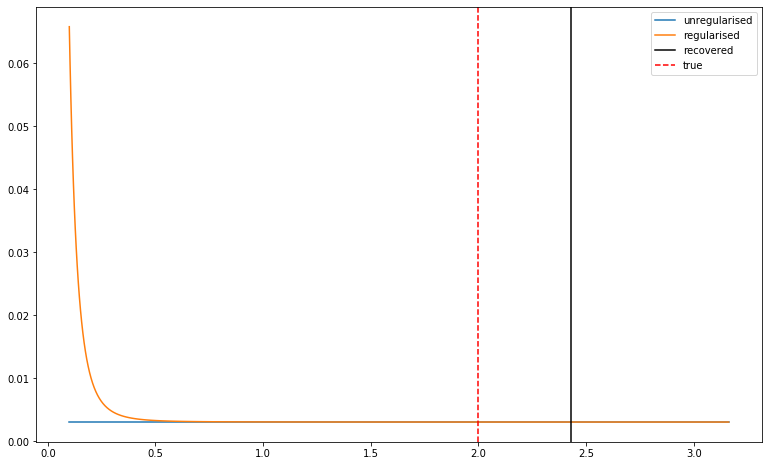

In [33]:
fs = [pf['f'] for pf in profile]
fs_r = [fff12(pf['x'], rho) for pf in profile_r]
plt.semilogx(pvals.flatten(), fs, label='unregularised')
plt.semilogx(pvals.flatten(), fs_r, label='regularised')
plt.axvline(float(pref[0]), color='k', label='recovered')
plt.axvline(float(p_true[0]), color='r', linestyle='--', label='true')
plt.legend()
plt.xscale('linear')
plt.yscale('linear')

In [34]:
idx = 115
rho = prange[idx]
pref = getp(solutions[idx]['x'])

pvals_1 = np.logspace(-1, 0.5, num=100)
profile_1 = []
profile_1r = []
for pval in pvals_1:
    lbg = np.array([-myinf, pval, -myinf])
    ubg = np.array([myinf, pval, myinf])
    profile_1.append(profiler(x0=solutions[idx]['x'], p=[rho, 0], lbg=lbg, ubg=ubg))
    profile_1r.append(profiler(x0=solutions[idx]['x'], p=[rho, (np.log10(p)+6)*1e-5], lbg=lbg, ubg=ubg))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   2  4.4818509e+00 0.00e+00 7.28e+00  -1.7 6.91e-02   2.0 1.00e+00 1.00e+00f  1
   3  2.4900588e+00 0.00e+00 3.80e+00  -1.7 9.42e-02   1.5 1.00e+00 1.00e+00f  1
   4  1.8081814e+00 0.00e+00 1.23e+00  -1.7 7.50e-02   1.0 1.00e+00 1.00e+00f  1
   5  1.7141488e+00 0.00e+00 1.81e-01  -1.7 4.25e-02   0.6 1.00e+00 1.00e+00f  1
   6  1.6593957e+00 0.00e+00 1.29e-01  -2.5 1.05e-01   0.1 1.00e+00 1.00e+00f  1
   7  1.5520422e+00 0.00e+00 9.25e-02  -2.5 2.25e-01  -0.4 1.00e+00 1.00e+00f  1
   8  1.4071141e+00 0.00e+00 5.52e-02  -2.5 4.02e-01  -0.9 1.00e+00 1.00e+00f  1
   9  1.3104565e+00 0.00e+00 4.94e-02  -2.5 4.94e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2873164e+00 0.00e+00 1.88e-02  -2.5 3.16e-01  -1.8 1.00e+00 1.00e+00f  1
  11  1.2859125e+00 0.00e+00 1.28e-03  -3.8 8.89e-02  -2.3 1.00e+00 1.00e+00f  1
  12  1.2858973e+00 0.00e+00 1.63e-05  -5.7 9.65e-03  -2.8 1.00e+00 1.00e+00f  1
  13  1.2858972e+00 0.00e+00

   4  1.6275193e+00 0.00e+00 1.07e+00  -1.7 6.71e-02   1.0 1.00e+00 1.00e+00f  1
   5  1.5558394e+00 0.00e+00 1.46e-01  -1.7 3.95e-02   0.6 1.00e+00 1.00e+00f  1
   6  1.5084014e+00 0.00e+00 1.20e-01  -2.5 9.72e-02   0.1 1.00e+00 1.00e+00f  1
   7  1.4149474e+00 0.00e+00 8.56e-02  -2.5 2.08e-01  -0.4 1.00e+00 1.00e+00f  1
   8  1.2897164e+00 0.00e+00 5.13e-02  -2.5 3.74e-01  -0.9 1.00e+00 1.00e+00f  1
   9  1.2070746e+00 0.00e+00 3.96e-02  -2.5 4.60e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1874666e+00 0.00e+00 1.50e-02  -2.5 2.94e-01  -1.8 1.00e+00 1.00e+00f  1
  11  1.1862815e+00 0.00e+00 1.00e-03  -3.8 8.29e-02  -2.3 1.00e+00 1.00e+00f  1
  12  1.1862686e+00 0.00e+00 1.52e-05  -5.7 9.01e-03  -2.8 1.00e+00 1.00e+00f  1
  13  1.1862686e+00 0.00e+00 1.98e-07  -8.6 3.51e-04  -3.2 1.00e+00 1.00e+00f  1
  14  1.1862686e+00 0.00e+00 8.87e-10  -8.6 4.72e-06  -3.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5126297e-03 3.55e-01 2.46e-04  -1.0 0.00e+00    -  0.00e+00 0.

   8  9.9676836e-01 0.00e+00 4.14e-02  -2.5 3.02e-01  -0.9 1.00e+00 1.00e+00f  1
   9  9.4469711e-01 0.00e+00 2.03e-02  -2.5 3.69e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.3272661e-01 0.00e+00 7.67e-03  -3.8 2.36e-01  -1.8 1.00e+00 1.00e+00f  1
  11  9.3201492e-01 0.00e+00 4.89e-04  -3.8 6.66e-02  -2.3 1.00e+00 1.00e+00f  1
  12  9.3200724e-01 0.00e+00 1.23e-05  -5.7 7.25e-03  -2.8 1.00e+00 1.00e+00f  1
  13  9.3200723e-01 0.00e+00 1.59e-07  -8.6 2.82e-04  -3.2 1.00e+00 1.00e+00f  1
  14  9.3200723e-01 0.00e+00 7.10e-10  -8.6 3.77e-06  -3.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   9.3200722611385256e-01    9.3200722611385256e-01
Dual infeasibility......:   7.0955619158041827e-10    7.0955619158041827e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   2  2.1852497e+00 0.00e+00 5.27e+00  -1.7 5.05e-02   2.0 1.00e+00 1.00e+00f  1
   3  1.2597545e+00 0.00e+00 2.40e+00  -1.7 6.24e-02   1.5 1.00e+00 1.00e+00f  1
   4  1.0308740e+00 0.00e+00 5.82e-01  -1.7 4.05e-02   1.0 1.00e+00 1.00e+00f  1
   5  1.0068592e+00 0.00e+00 1.05e-01  -1.7 2.84e-02   0.6 1.00e+00 1.00e+00f  1
   6  9.8128419e-01 0.00e+00 8.53e-02  -2.5 6.91e-02   0.1 1.00e+00 1.00e+00f  1
   7  9.3105231e-01 0.00e+00 6.01e-02  -2.5 1.46e-01  -0.4 1.00e+00 1.00e+00f  1
   8  8.6618217e-01 0.00e+00 3.67e-02  -2.5 2.68e-01  -0.9 1.00e+00 1.00e+00f  1
   9  8.2568866e-01 0.00e+00 1.49e-02  -2.5 3.26e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.1655919e-01 0.00e+00 5.34e-03  -3.8 2.09e-01  -1.8 1.00e+00 1.00e+00f  1
  11  8.1602234e-01 0.00e+00 3.32e-04  -3.8 5.88e-02  -2.3 1.00e+00 1.00e+00f  1
  12  8.1601658e-01 0.00e+00 1.08e-05  -5.7 6.39e-03  -2.8 1.00e+00 1.00e+00f  1
  13  8.1601657e-01 0.00e+00

   8  7.3522086e-01 0.00e+00 3.19e-02  -2.5 2.33e-01  -0.9 1.00e+00 1.00e+00f  1
   9  7.0503958e-01 0.00e+00 1.29e-02  -2.5 2.82e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.9839605e-01 0.00e+00 3.49e-03  -3.8 1.80e-01  -1.8 1.00e+00 1.00e+00f  1
  11  6.9801071e-01 0.00e+00 2.57e-04  -3.8 5.07e-02  -2.3 1.00e+00 1.00e+00f  1
  12  6.9800661e-01 0.00e+00 9.31e-06  -5.7 5.50e-03  -2.8 1.00e+00 1.00e+00f  1
  13  6.9800661e-01 0.00e+00 1.20e-07  -8.6 2.12e-04  -3.2 1.00e+00 1.00e+00f  1
  14  6.9800661e-01 0.00e+00 5.30e-10  -8.6 2.82e-06  -3.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   6.9800660875916043e-01    6.9800660875916043e-01
Dual infeasibility......:   5.2982818132818466e-10    5.2982818132818466e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   5  6.8704377e-01 0.00e+00 7.78e-02  -1.7 2.10e-02   0.6 1.00e+00 1.00e+00f  1
   6  6.7208740e-01 0.00e+00 6.27e-02  -2.5 5.08e-02   0.1 1.00e+00 1.00e+00f  1
   7  6.4308516e-01 0.00e+00 4.36e-02  -2.5 1.06e-01  -0.4 1.00e+00 1.00e+00f  1
   8  6.0694498e-01 0.00e+00 2.70e-02  -2.5 1.97e-01  -0.9 1.00e+00 1.00e+00f  1
   9  5.8078540e-01 0.00e+00 1.94e-02  -3.8 4.36e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.8078540e-01 0.00e+00 4.35e-07  -3.8 9.35e-06  -1.3 1.00e+00 1.00e+00f  1
  11  5.8078540e-01 0.00e+00 7.37e-14  -8.6 1.95e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   5.8078539550597552e-01    5.8078539550597552e-01
Dual infeasibility......:   7.3718808835110394e-14    7.3718808835110394e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   2  8.4959748e-01 0.00e+00 3.22e+00  -1.7 3.12e-02   2.0 1.00e+00 1.00e+00f  1
   3  5.4899253e-01 0.00e+00 1.25e+00  -1.7 3.42e-02   1.5 1.00e+00 1.00e+00f  1
   4  4.9670620e-01 0.00e+00 2.26e-01  -1.7 1.77e-02   1.0 1.00e+00 1.00e+00f  1
   5  4.9097803e-01 0.00e+00 5.94e-02  -1.7 1.60e-02   0.6 1.00e+00 1.00e+00f  1
   6  4.8167626e-01 0.00e+00 4.76e-02  -2.5 3.85e-02   0.1 1.00e+00 1.00e+00f  1
   7  4.6386923e-01 0.00e+00 3.27e-02  -2.5 7.95e-02  -0.4 1.00e+00 1.00e+00f  1
   8  4.4238637e-01 0.00e+00 2.05e-02  -2.5 1.49e-01  -0.9 1.00e+00 1.00e+00f  1
   9  4.3033456e-01 0.00e+00 8.16e-03  -3.8 1.79e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2787833e-01 0.00e+00 1.72e-03  -3.8 1.13e-01  -1.8 1.00e+00 1.00e+00f  1
  11  4.2774190e-01 0.00e+00 1.60e-04  -3.8 3.15e-02  -2.3 1.00e+00 1.00e+00f  1
  12  4.2774049e-01 0.00e+00 5.72e-06  -5.7 3.38e-03  -2.8 1.00e+00 1.00e+00f  1
  13  4.2774049e-01 0.00e+00

   5  3.6064454e-01 0.00e+00 4.60e-02  -2.5 1.24e-02   0.6 1.00e+00 1.00e+00f  1
   6  3.5471412e-01 0.00e+00 3.66e-02  -2.5 2.97e-02   0.1 1.00e+00 1.00e+00f  1
   7  3.2190376e-01 0.00e+00 5.64e-03  -2.5 4.21e-01    -  1.00e+00 1.00e+00f  1
   8  3.2190375e-01 0.00e+00 7.74e-09  -3.8 6.34e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   3.2190375457164033e-01    3.2190375457164033e-01
Dual infeasibility......:   7.7425106326245441e-09    7.7425106326245441e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.7425106326245441e-09    7.7425106326245441e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequal

  13  1.6792492e-01 0.00e+00 2.66e-08  -8.6 4.72e-05  -3.2 1.00e+00 1.00e+00f  1
  14  1.6792492e-01 0.00e+00 1.10e-10  -8.6 5.87e-07  -3.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.6792492386322957e-01    1.6792492386322957e-01
Dual infeasibility......:   1.1046873138464974e-10    1.1046873138464974e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.1046873138464974e-10    1.1046873138464974e-10


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 15
N

   1  8.8986600e-02 0.00e+00 1.12e+01  -2.5 5.59e-01    -  1.00e+00 1.00e+00h  1
   2  6.1775458e-02 0.00e+00 2.99e-02  -2.5 1.24e-02   0.0 1.00e+00 1.00e+00f  1
   3  6.1030674e-02 0.00e+00 4.75e-03  -2.5 1.43e-02  -0.5 1.00e+00 1.00e+00f  1
   4  6.0166234e-02 0.00e+00 2.36e-04  -3.8 6.71e-02    -  1.00e+00 1.00e+00f  1
   5  6.0166234e-02 0.00e+00 3.65e-12  -5.7 1.33e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   6.0166233582414047e-02    6.0166233582414047e-02
Dual infeasibility......:   3.6479708143133394e-12    3.6479708143133394e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.6479708143133394e-12    3.6479708143133394e-12


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

  nlp_grad_f  | 308.00us ( 51.33us) 309.87us ( 51.64us)         6
  nlp_hess_l  |   5.01ms (  1.25ms)   5.01ms (  1.25ms)         4
   nlp_jac_g  |  19.00us (  3.17us)  20.27us (  3.38us)         6
       total  |   9.23ms (  9.23ms)   9.11ms (  9.11ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequali

   6  9.4128417e-02 0.00e+00 2.37e-02  -2.5 1.92e-02   0.1 1.00e+00 1.00e+00f  1
   7  8.9196443e-02 0.00e+00 1.46e-02  -3.8 3.55e-02  -0.4 1.00e+00 1.00e+00f  1
   8  8.6116757e-02 0.00e+00 5.69e-03  -3.8 4.15e-02  -0.9 1.00e+00 1.00e+00f  1
   9  8.5394471e-02 0.00e+00 2.02e-03  -3.8 4.42e-02  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5305956e-02 0.00e+00 3.89e-04  -3.8 2.55e-02  -1.8 1.00e+00 1.00e+00f  1
  11  8.5302016e-02 0.00e+00 3.14e-05  -5.7 6.18e-03  -2.3 1.00e+00 1.00e+00f  1
  12  8.5301986e-02 0.00e+00 9.15e-07  -5.7 5.41e-04  -2.8 1.00e+00 1.00e+00f  1
  13  8.5301986e-02 0.00e+00 9.07e-09  -8.6 1.61e-05  -3.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   8.5301986235773647e-02    8.5301986235773647e-02
Dual infeasibility......:   9.0683704712102298e-09    9.0683704712102298e-09
Constraint viol

Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0643581e-03 2.91e-01 3.37e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.0899987e+00 0.00e+00 8.95e+01  -1.7 1.59e+00    -  1.00e+00 1.00e+00h  1
   2  6.1069312e-01 0.00e+00 4.75e+00  -1.7 4.44e-0

   6  5.7948858e-01 0.00e+00 1.70e-01  -1.7 1.38e-01   0.1 1.00e+00 1.00e+00f  1
   7  3.9633841e-01 0.00e+00 8.69e-02  -2.5 2.11e-01  -0.4 1.00e+00 1.00e+00f  1
   8  3.2512772e-01 0.00e+00 5.12e-02  -2.5 1.86e-01  -0.9 1.00e+00 1.00e+00f  1
   9  3.1405732e-01 0.00e+00 8.89e-03  -2.5 1.95e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1269117e-01 0.00e+00 1.61e-03  -3.8 1.06e-01  -1.8 1.00e+00 1.00e+00f  1
  11  3.1263578e-01 0.00e+00 1.17e-04  -3.8 2.30e-02  -2.3 1.00e+00 1.00e+00f  1
  12  3.1263541e-01 0.00e+00 2.96e-06  -5.7 1.75e-03  -2.8 1.00e+00 1.00e+00f  1
  13  3.1263541e-01 0.00e+00 2.51e-08  -8.6 4.44e-05  -3.2 1.00e+00 1.00e+00f  1
  14  3.1263541e-01 0.00e+00 6.86e-11  -9.0 3.65e-07  -3.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   3.1263541083300228e-01    3.1263541083300228e-01
Dual infeas

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0643581e-03 5.80e-01 3.37e-04  -1.0 0.00e+00    -  0.00e+00 0.

   4  6.4317181e+00 0.00e+00 1.06e+00  -1.7 9.57e-02   1.0 1.00e+00 1.00e+00f  1
   5  4.8682769e+00 0.00e+00 9.13e-01  -1.7 2.46e-01   0.6 1.00e+00 1.00e+00f  1
   6  2.5361093e+00 0.00e+00 6.25e-01  -1.7 4.92e-01   0.1 1.00e+00 1.00e+00f  1
   7  9.5710806e-01 0.00e+00 8.72e-01  -1.7 5.90e-01  -0.4 1.00e+00 1.00e+00f  1
   8  6.2158769e-01 0.00e+00 2.34e-01  -1.7 4.35e-01  -0.9 1.00e+00 1.00e+00f  1
   9  5.7913134e-01 0.00e+00 2.06e-02  -1.7 4.51e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7325431e-01 0.00e+00 3.41e-03  -3.8 2.25e-01  -1.8 1.00e+00 1.00e+00f  1
  11  5.7304150e-01 0.00e+00 3.04e-04  -3.8 4.24e-02  -2.3 1.00e+00 1.00e+00f  1
  12  5.7304006e-01 0.00e+00 4.69e-06  -5.7 2.72e-03  -2.8 1.00e+00 1.00e+00f  1
  13  5.7304006e-01 0.00e+00 3.17e-08  -8.6 5.61e-05  -3.2 1.00e+00 1.00e+00f  1
  14  5.7304006e-01 0.00e+00 1.13e-10  -8.6 6.03e-07  -3.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   3  1.7314495e+01 0.00e+00 8.98e+00  -1.7 1.40e-01   1.5 1.00e+00 1.00e+00f  1
   4  1.4767318e+01 0.00e+00 1.85e+00  -1.7 1.67e-01   1.0 1.00e+00 1.00e+00f  1
   5  1.0249103e+01 0.00e+00 1.54e+00  -1.7 4.15e-01   0.6 1.00e+00 1.00e+00f  1
   6  4.3667038e+00 0.00e+00 1.73e+00  -1.7 7.64e-01   0.1 1.00e+00 1.00e+00f  1
   7  1.2431553e+00 0.00e+00 1.79e+00  -1.7 7.97e-01  -0.4 1.00e+00 1.00e+00f  1
   8  7.4730010e-01 0.00e+00 3.17e-01  -1.7 5.85e-01  -0.9 1.00e+00 1.00e+00f  1
   9  6.8117080e-01 0.00e+00 2.74e-02  -1.7 6.00e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7171762e-01 0.00e+00 5.78e-03  -3.8 2.84e-01  -1.8 1.00e+00 1.00e+00f  1
  11  6.7138616e-01 0.00e+00 7.00e-04  -3.8 5.00e-02  -2.3 1.00e+00 1.00e+00f  1
  12  6.7138378e-01 0.00e+00 1.06e-05  -5.7 2.96e-03  -2.8 1.00e+00 1.00e+00f  1
  13  6.7138378e-01 0.00e+00 3.32e-08  -8.6 5.90e-05  -3.2 1.00e+00 1.00e+00f  1
  14  6.7138378e-01 0.00e+00

  12  7.5152982e-01 0.00e+00 2.29e-05  -3.8 3.08e-03  -2.8 1.00e+00 1.00e+00f  1
  13  7.5152981e-01 0.00e+00 4.53e-08  -5.7 8.06e-05  -3.2 1.00e+00 1.00e+00f  1
  14  7.5152981e-01 0.00e+00 2.20e-10  -8.6 1.17e-06  -3.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   7.5152981000459829e-01    7.5152981000459829e-01
Dual infeasibility......:   2.1980685587646986e-10    2.1980685587646986e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.1980685587646986e-10    2.1980685587646986e-10


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobi

   0  3.0643581e-03 1.38e+00 3.37e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  9.7507250e+02 0.00e+00 1.94e+03  -1.0 7.54e+00    -  1.00e+00 1.00e+00h  1
   2  1.6657750e+02 0.00e+00 1.91e+02  -1.0 6.64e-01   2.0 1.00e+00 1.00e+00f  1
   3  8.4432032e+01 0.00e+00 2.59e+01  -1.0 2.60e-01   1.5 1.00e+00 1.00e+00f  1
   4  6.6027057e+01 0.00e+00 5.07e+00  -1.0 4.56e-01   1.0 1.00e+00 1.00e+00f  1
   5  3.6528918e+01 0.00e+00 4.25e+00  -1.0 1.02e+00   0.6 1.00e+00 1.00e+00f  1
   6  9.7372535e+00 0.00e+00 9.00e+00  -1.0 1.52e+00   0.1 1.00e+00 1.00e+00f  1
   7  1.7301665e+00 0.00e+00 4.57e+00  -1.0 1.13e+00  -0.4 1.00e+00 1.00e+00f  1
   8  9.8141905e-01 0.00e+00 3.16e-01  -1.0 9.89e-01  -0.9 1.00e+00 1.00e+00f  1
   9  8.3422514e-01 0.00e+00 4.41e-02  -1.7 9.68e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.1344552e-01 0.00e+00 2.64e-02  -2.5 4.10e-01  -1.8 1.00e+00 1.00e+00f  1
  11  8.1270224e-01 0.00e+00

   9  6.4335229e+01 0.00e+00 6.70e+00  -1.0 1.21e+00   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5402956e-01 0.00e+00 5.40e+01  -1.0 3.89e+00    -  1.00e+00 1.00e+00f  1
  11  8.5390859e-01 0.00e+00 6.13e-04  -1.0 3.79e-04   0.2 1.00e+00 1.00e+00f  1
  12  8.5390859e-01 0.00e+00 3.17e-09  -5.7 2.52e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   8.5390858940286907e-01    8.5390858940286907e-01
Dual infeasibility......:   3.1673214606620093e-09    3.1673214606620093e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.1673214606620093e-09    3.1673214606620093e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations        

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0643581e-03 1.98e+00 3.37e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.1672746e+03 0.00e+00 3.90e+03  -1.0 1.08e+01    -  1.00e+00 1.00e+00h  1
   2  3.6028417e+03 0.00e+00 1.16e+03  -1.0 1.16e-01   4.0 1.00e+00 1.00e+00f  1
   3  2.5020726e+03 0.00e+00 9.15e+02  -1.0 2.67e-01   3.5 1.00e+00 1.00e+00f  1
   4  1.2312626e+03 0.00e+00 5.62e+02  -1.0 4.45e-01   3.0 1.00e+00 1.00e+00f  1
   5  5.4830505e+02 0.00e+00 2.41e+02  -1.0 4.66e-01   2.6 1.00e+00 1.00e+00f  1
   6  3.9425150e+02 0.00e+00 5.73e+01  -1.0 2.78e-01   2.1 1.00e+00 1.00e+00f  1
   7  3.4693390e+02 0.00e+00 1.51e+01  -1.0 3.66e-01   1.6 1.00e+00 1.00e+00f  1
   8  2.5631597e+02 0.00e+00 1.30e+01  -1.0 9.49e-01   1.1 1.00e+00 1.00e+00f  1
   9  1.1740487e+02 0.00e+00 2.02e+01  -1.0 1.92e+00   0.7 1.

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 266.00us ( 17.73us) 266.21us ( 17.75us)        15
       nlp_g  |  39.00us (  2.60us)  36.42us (  2.43us)        15
    nlp_grad  |  46.00us ( 46.00us)  44.98us ( 44.98us)         1
  nlp_grad_f  | 659.00us ( 41.19us) 704.18us ( 44.01us)        16
  nlp_hess_l  |  15.92ms (  1.14ms)  16.00ms (  1.14ms)        14
   nlp_jac_g  |  42.00us (  2.62us)  39.36us (  2.46us)        16
       total  |  26.17ms ( 26.17ms)  25.68ms ( 25.68ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        0
        

  10  9.9289373e-01 0.00e+00 1.29e+02  -1.0 6.71e+00    -  1.00e+00 1.00e+00f  1
  11  9.8967033e-01 0.00e+00 3.20e-03  -1.0 1.58e-03   0.2 1.00e+00 1.00e+00f  1
  12  9.8967031e-01 0.00e+00 6.77e-06  -3.8 1.33e-05  -0.3 1.00e+00 1.00e+00f  1
  13  9.8967030e-01 0.00e+00 1.06e-07  -8.6 9.10e-05    -  1.00e+00 1.00e+00f  1
  14  9.8967030e-01 0.00e+00 3.89e-13  -8.6 4.90e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   9.8967030129348321e-01    9.8967030129348321e-01
Dual infeasibility......:   3.8921643685796425e-13    3.8921643685796425e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.8921643685796425e-13    3.8921643685796425e-13


Number of objective function evaluations             = 15
Number of objective gradient evaluations        

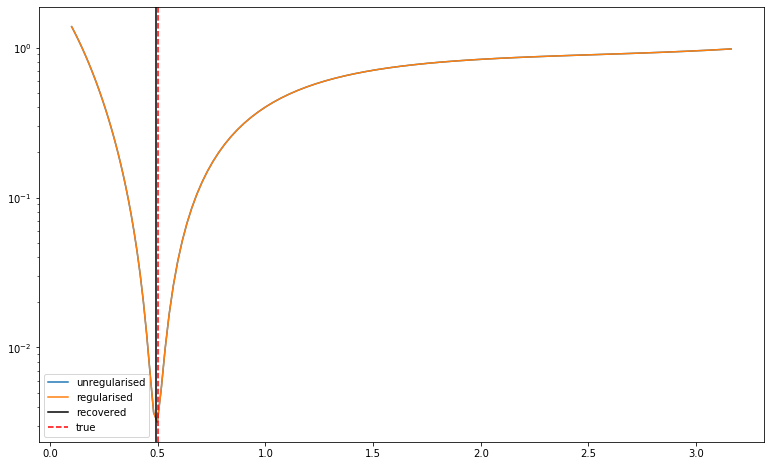

In [35]:
fs_1 = [pf['f'] for pf in profile_1]
fs_r1 = [fff12(pf['x'], rho) for pf in profile_1r]
plt.semilogx(pvals_1.flatten(), fs_1, label='unregularised')
plt.semilogx(pvals_1.flatten(), fs_r1, label='regularised')
plt.axvline(float(pref[1]), color='k', label='recovered')
plt.axvline(float(p_true[1]), color='r', linestyle='--', label='true')
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')

In [36]:
idx = 115
rho = prange[idx]
pref = getp(solutions[idx]['x'])

pvals_2 = np.logspace(-1, 0.75, num=100)
profile_2 = []
profile_2r = []
for pval in pvals_2:
    lbg = np.array([-myinf, -myinf, pval])
    ubg = np.array([myinf, myinf, pval])
    profile_2.append(profiler(x0=solutions[idx]['x'], p=[rho, 0], lbg=lbg, ubg=ubg))
    profile_2r.append(profiler(x0=solutions[idx]['x'], p=[rho, (np.log10(p)+6)*1e-5], lbg=lbg, ubg=ubg))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  2.6660117e-02 0.00e+00 2.55e+01  -1.7 1.05e+01    -  1.00e+00 1.00e+00f  1
   8  3.5361760e-03 0.00e+00 3.46e+00  -1.7 3.61e+00    -  1.00e+00 1.00e+00f  1
   9  3.0646887e-03 0.00e+00 9.33e-02  -1.7 8.11e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 7.05e-05  -2.5 2.55e-02    -  1.00e+00 1.00e+00f  1
  11  3.0641956e-03 0.00e+00 1.01e-10  -5.7 3.71e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836808e-03    3.0641956212836808e-03
Dual infeasibility......:   1.0118792696442499e-10    1.0118792696442499e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.0118792696442499e-10    1.0118792696442499e-10


Number of objective funct

  10  3.0641956e-03 0.00e+00 2.07e-07  -3.8 1.48e-03    -  1.00e+00 1.00e+00f  1
  11  3.0641956e-03 0.00e+00 5.81e-13  -8.6 1.36e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212835940e-03    3.0641956212835940e-03
Dual infeasibility......:   5.8089969581710951e-13    5.8089969581710951e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   5.8089969581710951e-13    5.8089969581710951e-13


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 12
N

   1  2.1899233e+02 1.11e-16 9.74e+02  -1.0 2.25e+00    -  1.00e+00 1.00e+00h  1
   2  1.2267659e+01 0.00e+00 1.89e+02  -1.0 1.40e+00   0.0 1.00e+00 1.00e+00f  1
   3  3.8198727e+00 0.00e+00 5.15e+00  -1.0 8.92e-01  -0.5 1.00e+00 1.00e+00f  1
   4  2.4001960e+00 0.00e+00 1.11e+00  -1.0 8.78e-01  -1.0 1.00e+00 1.00e+00f  1
   5  1.8592483e+00 0.00e+00 6.49e+01  -1.0 4.32e+01    -  1.00e+00 5.00e-01f  2
   6  1.5022012e+00 0.00e+00 1.85e+01  -1.0 1.38e+01    -  1.00e+00 1.00e+00f  1
   7  7.7521828e-01 0.00e+00 1.89e+01  -1.0 1.06e+01    -  1.00e+00 1.00e+00f  1
   8  5.3997055e-01 0.00e+00 3.49e-01  -1.0 4.76e-01  -1.4 1.00e+00 1.00e+00f  1
   9  2.3326894e-01 0.00e+00 4.65e+00  -1.7 2.14e+02    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2635507e-01 0.00e+00 4.47e+00  -1.7 9.29e+00    -  1.00e+00 1.00e+00f  1
  11  1.1569169e-01 0.00e+00 1.25e-01  -1.7 8.24e-01    -  1.00e+00 1.00e+00f  1
  12  1.1568115e-01 0.00e+00

   1  2.0323650e+02 1.11e-16 9.38e+02  -1.0 2.21e+00    -  1.00e+00 1.00e+00h  1
   2  1.0324241e+01 0.00e+00 1.66e+02  -1.0 1.33e+00   0.0 1.00e+00 1.00e+00f  1
   3  3.4210927e+00 0.00e+00 5.38e+00  -1.0 8.41e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.9181391e+00 0.00e+00 3.49e+00  -1.0 3.33e+02    -  1.00e+00 3.12e-02f  6
   5  2.4296986e-01 0.00e+00 2.58e+01  -1.0 3.58e+00    -  1.00e+00 1.00e+00f  1
   6  9.3483846e-02 0.00e+00 1.06e+01  -1.0 4.74e+00    -  1.00e+00 1.00e+00f  1
   7  8.0324163e-02 0.00e+00 8.59e-01  -1.0 1.10e+00    -  1.00e+00 1.00e+00f  1
   8  8.0248751e-02 0.00e+00 7.11e-03  -1.7 1.38e-01    -  1.00e+00 1.00e+00f  1
   9  8.0248745e-02 0.00e+00 4.49e-07  -3.8 9.58e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.0248745e-02 0.00e+00 9.97e-14  -8.6 9.95e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objecti

   6  6.4517731e-02 0.00e+00 5.67e+00  -1.0 3.66e+00    -  1.00e+00 1.00e+00f  1
   7  5.5605612e-02 0.00e+00 4.65e-01  -1.0 9.40e-01    -  1.00e+00 1.00e+00f  1
   8  5.5531000e-02 0.00e+00 4.89e-03  -1.7 1.35e-01    -  1.00e+00 1.00e+00f  1
   9  5.5530989e-02 0.00e+00 5.33e-07  -3.8 1.53e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5530989e-02 0.00e+00 5.51e-14  -8.6 3.04e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   5.5530988880593830e-02    5.5530988880593830e-02
Dual infeasibility......:   5.5067062021407764e-14    5.5067062021407764e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   5.5067062021407764e-14    5.5067062021407764e-14


Number of objective funct

   9  3.0641956e-03 0.00e+00 2.80e-07  -3.8 1.68e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 3.65e-13  -8.6 4.46e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836413e-03    3.0641956212836413e-03
Dual infeasibility......:   3.6453300111472743e-13    3.6453300111472743e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.6453300111472743e-13    3.6453300111472743e-13


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobi

   1  1.4177592e+02 1.11e-16 7.84e+02  -1.0 2.02e+00    -  1.00e+00 1.00e+00h  1
   2  4.9017366e+00 0.00e+00 8.98e+01  -1.0 1.06e+00   0.0 1.00e+00 1.00e+00f  1
   3  1.9599458e+00 0.00e+00 4.28e+00  -1.0 6.70e-01  -0.5 1.00e+00 1.00e+00f  1
   4  6.6247379e-01 0.00e+00 1.63e+01  -1.0 1.41e+01    -  1.00e+00 5.00e-01f  2
   5  4.4828143e-02 0.00e+00 3.70e+00  -1.0 2.03e+00    -  1.00e+00 1.00e+00f  1
   6  2.7013734e-02 0.00e+00 7.85e-02  -1.0 6.91e-01    -  1.00e+00 1.00e+00f  1
   7  2.6920189e-02 0.00e+00 1.79e-03  -2.5 4.99e-02    -  1.00e+00 1.00e+00f  1
   8  2.6920186e-02 0.00e+00 1.30e-08  -3.8 2.23e-04    -  1.00e+00 1.00e+00f  1
   9  2.6920186e-02 0.00e+00 9.53e-14  -9.0 8.94e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.6920185980735752e-02    2.6920185980735752e-02
Dual infeasibility......:   9.5271013300646246e-14    9.5271013300646246e-14
Constraint viola

  10  3.0641956e-03 0.00e+00 6.22e-14  -8.6 1.50e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212835962e-03    3.0641956212835962e-03
Dual infeasibility......:   6.2206967008093805e-14    6.2206967008093805e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   6.2206967008093805e-14    6.2206967008093805e-14


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT 

   1  9.1553391e+01 1.11e-16 6.30e+02  -1.0 1.81e+00    -  1.00e+00 1.00e+00h  1
   2  2.2568522e+00 0.00e+00 4.17e+01  -1.0 7.86e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.3931728e+00 0.00e+00 1.32e+01  -1.0 3.63e+01    -  1.00e+00 1.25e-01f  4
   4  4.5941454e-02 0.00e+00 8.48e-01  -1.0 2.51e+00    -  1.00e+00 1.00e+00f  1
   5  1.5242041e-02 0.00e+00 1.70e-01  -1.7 1.16e+00    -  1.00e+00 1.00e+00f  1
   6  1.3815721e-02 0.00e+00 8.11e-03  -2.5 2.56e-01    -  1.00e+00 1.00e+00f  1
   7  1.3809473e-02 0.00e+00 5.23e-05  -3.8 2.08e-02    -  1.00e+00 1.00e+00f  1
   8  1.3809473e-02 0.00e+00 7.02e-10  -5.7 9.99e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3809472508458058e-02    1.3809472508458058e-02
Dual infeasibility......:   7.0227947659680726e-10    7.0227947659680726e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   0  4.5126297e-03 1.63e+00 2.46e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.1258204e+01 0.00e+00 5.15e+02  -1.0 1.63e+00    -  1.00e+00 1.00e+00h  1
   2  1.1918301e+00 0.00e+00 2.02e+01  -1.0 5.89e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.0081328e+00 0.00e+00 9.05e+00  -1.0 4.27e+00    -  1.00e+00 1.00e+00f  1
   4  5.2409012e-01 0.00e+00 3.34e-01  -1.0 3.73e-01  -0.5 1.00e+00 1.00e+00f  1
   5  6.6451417e-02 0.00e+00 2.81e+00  -1.7 2.02e+00    -  1.00e+00 1.00e+00f  1
   6  1.4132485e-02 0.00e+00 4.62e-01  -1.7 1.53e+00    -  1.00e+00 1.00e+00f  1
   7  9.7410956e-03 0.00e+00 1.92e-02  -1.7 8.56e-02    -  1.00e+00 1.00e+00f  1
   8  9.7398756e-03 0.00e+00 8.32e-06  -3.8 5.42e-03    -  1.00e+00 1.00e+00f  1
   9  9.7398756e-03 0.00e+00 3.90e-11  -8.6 8.08e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   9.7398755718067758e-03    9.7398755718067758e-03
Dual infeasi

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0643581e-03 1.41e+00 3.37e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.4428644e+01 0.00e+00 3.86e+02  -1.0 1.41e+00    -  1.00e+00 1.00e+00h  1
   2  5.0813141e-01 0.00e+00 7.11e+00  -1.0 3.85e-01   0.0 1.00e+00 1.00e+00f  1
   3  7.3338612e-02 0.00e+00 1.41e+00  -1.0 1.66e+00    -  1.00e+00 1.00e+00f  1
   4  4.3977127e-03 0.00e+00 1.18e-01  -1.0 7.33e-01    -  1.00e+00 1.00e+00f  1
   5  3.0665043e-03 0.00e+00 9.47e-03  -2.5 1.65e-01    -  1.00e+00 1.00e+00f  1
   6  3.0641956e-03 0.00e+00 4.99e-06  -3.8 2.20e-03    -  1.00e+00 1.00e+00f  1
   7  3.0641956e-03 0.00e+00 1.81e-12  -8.6 1.17e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836474e-03    3.0641956212836474e-03
Dual infeasibility......:   1.8110865454903924e-12    1.8110865454903924e-12
Constraint viola

   3  1.0930159e-02 0.00e+00 4.08e-01  -1.0 6.71e-01    -  1.00e+00 1.00e+00f  1
   4  5.7856944e-03 0.00e+00 1.52e-02  -1.7 2.13e-01    -  1.00e+00 1.00e+00f  1
   5  5.7784657e-03 0.00e+00 2.32e-05  -3.8 4.15e-03    -  1.00e+00 1.00e+00f  1
   6  5.7784657e-03 0.00e+00 1.10e-10  -5.7 1.90e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   5.7784656628458737e-03    5.7784656628458737e-03
Dual infeasibility......:   1.0976396657910725e-10    1.0976396657910725e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.0976396657910725e-10    1.0976396657910725e-10


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequal


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 20.00us) 120.09us ( 20.02us)         6
       nlp_g  |  17.00us (  2.83us)  16.43us (  2.74us)         6
    nlp_grad  |  52.00us ( 52.00us)  52.14us ( 52.14us)         1
  nlp_grad_f  | 339.00us ( 48.43us) 339.49us ( 48.50us)         7
  nlp_hess_l  |   6.12ms (  1.22ms)   6.13ms (  1.23ms)         5
   nlp_jac_g  |  20.00us (  2.86us)  20.00us (  2.86us)         7
       total  |  12.25ms ( 12.25ms)  12.24ms ( 12.24ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     1431

Total number of variables............................:       53
                     variables with only 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0643581e-03 2.71e-01 3.37e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.9186272e-02 0.00e+00 1.41e+01  -1.7 2.71e-01    -  1.00e+00 1.00e+00h  1
   2  3.0641958e-03 0.00e+00 3.40e-02  -1.7 2.70e-02    -  1.00e+00 1.00e+00f  1
   3  3.0641956e-03 0.00e+00 1.30e-11  -2.5 1.46e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836439e-03    3.0641956212836439e-03
Dual infeasibility......:   1.2979492589222652e-11    1.2979492589222652e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.2979492589222652e-11    1.2979492589222652e-11


Number of objective function evaluations             = 4
Number of objective gradient evaluations          

   1  9.2657593e+00 0.00e+00 2.00e+02  -1.0 1.02e+00    -  1.00e+00 1.00e+00h  1
   2  2.2917643e-02 0.00e+00 3.46e+00  -1.0 1.95e-01   0.0 1.00e+00 1.00e+00f  1
   3  4.9859447e-03 0.00e+00 5.39e-02  -1.0 9.48e-02    -  1.00e+00 1.00e+00f  1
   4  4.8745814e-03 0.00e+00 3.24e-04  -2.5 3.43e-02    -  1.00e+00 1.00e+00f  1
   5  4.8745689e-03 0.00e+00 6.15e-08  -5.7 1.06e-04    -  1.00e+00 1.00e+00f  1
   6  4.8745689e-03 0.00e+00 7.14e-14  -8.6 4.53e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   4.8745688782771222e-03    4.8745688782771222e-03
Dual infeasibility......:   7.1448286198018407e-14    7.1448286198018407e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.1448286198018407e-14    7.1448286198018407e-14


Number of objective functi

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0643581e-03 1.80e+00 3.37e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  8.9663615e+01 0.00e+00 6.23e+02  -1.0 1.80e+00    -  1.00e+00 1.00e+00h  1
   2  2.3761618e+00 0.00e+00 2.19e+01  -1.0 2.19e-01   2.0 1.00e+00 1.00e+00f  1
   3  1.3908884e+00 0.00e+00 2.46e+00  -1.0 7.39e-02   1.5 1.00e+00 1.00e+00f  1
   4  4.9259306e-01 0.00e+00 4.40e+00  -1.0 5.36e+00    -  1.00e+00 5.00e-01f  2
   5  3.9278867e-03 0.00e+00 1.22e-01  -1.0 2.60e+00    -  1.00e+00 1.00e+00f  1
   6  3.0644402e-03 0.00e+00 5.21e-03  -2.5 1.77e-02    -  1.00e+00 1.00e+00f  1
   7  3.0641956e-03 0.00e+00 1.06e-06  -3.8 1.52e-03    -  1.00e+00 1.00e+00f  1
   8  3.0641956e-03 0.00e+00 7.37e-13  -8.6 5.46e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836860e-03    3.0641956212836860e-03
Dual infeasi

   7  4.9636387e-02 0.00e+00 7.45e-01  -1.0 9.32e-01    -  1.00e+00 1.00e+00f  1
   8  5.7606242e-03 0.00e+00 1.88e-01  -1.7 6.43e-01    -  1.00e+00 1.00e+00f  1
   9  3.0653662e-03 0.00e+00 5.86e-03  -2.5 5.69e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0641956e-03 0.00e+00 5.00e-06  -3.8 2.60e-03    -  1.00e+00 1.00e+00f  1
  11  3.0641956e-03 0.00e+00 3.32e-11  -8.6 5.93e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.0641956212836162e-03    3.0641956212836162e-03
Dual infeasibility......:   3.3236446689462185e-11    3.3236446689462185e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.3236446689462185e-11    3.3236446689462185e-11


Number of objective funct

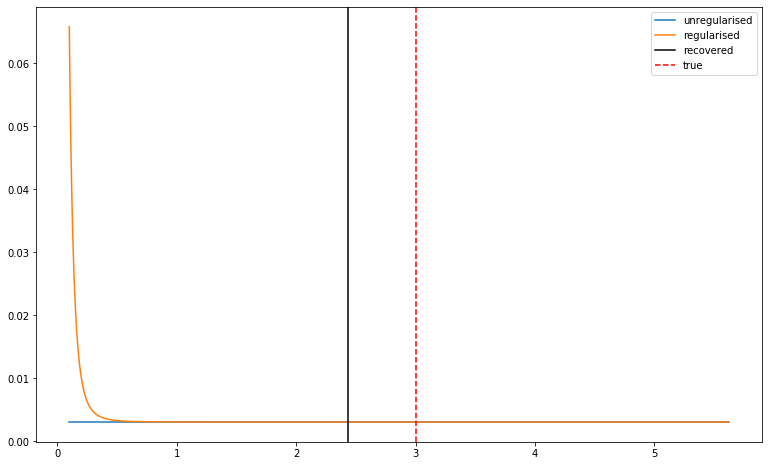

In [37]:
fs_2 = [pf['f'] for pf in profile_2]
fs_r2 = [fff12(pf['x'], rho) for pf in profile_2r]
plt.semilogx(pvals_2.flatten(), fs_2, label='unregularised')
plt.semilogx(pvals_2.flatten(), fs_r2, label='regularised')
plt.axvline(float(pref[2]), color='k', label='recovered')
plt.axvline(float(p_true[2]), color='r', linestyle='--', label='true')
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('linear')